# Students' attitude and behaviour PCA

### Authors:
Luca Mircea & Theo Trausan

### Date started:
14 April 2024

### Premise:
We tried applying PCA & clustering on a students spending dataset, but could not learn much from it because the dataset was too balanced and smooth, which made clustering and PCA decomposition difficult. Here we are attempting to apply the same frameworks to a dataset that we hope will yield better results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
students = pd.read_csv("students_atitude_and_behavior.csv")
students.head(5)

,Certification Course,Gender,Department,Height(CM),Weight(KG),10th Mark,12th Mark,college mark,hobbies,daily studing time,prefer to study in,salary expectation,Do you like your degree?,willingness to pursue a career based on their degree,social medai & video,Travelling Time,Stress Level,Financial Status,part-time job
0,No,Male,BCA,100.0,58.0,79.0,64.0,80.0,Video Games,0 - 30 minute,Morning,40000,No,50%,1.30 - 2 hour,30 - 60 minutes,Bad,Bad,No
1,No,Female,BCA,90.0,40.0,70.0,80.0,70.0,Cinema,30 - 60 minute,Morning,15000,Yes,75%,1 - 1.30 hour,0 - 30 minutes,Bad,Bad,No
2,Yes,Male,BCA,159.0,78.0,71.0,61.0,55.0,Cinema,1 - 2 Hour,Anytime,13000,Yes,50%,More than 2 hour,30 - 60 minutes,Awful,Bad,No
3,Yes,Female,BCA,147.0,20.0,70.0,59.0,58.0,Reading books,1 - 2 Hour,Anytime,1500000,No,50%,1.30 - 2 hour,0 - 30 minutes,Bad,good,No
4,No,Male,BCA,170.0,54.0,40.0,65.0,30.0,Video Games,30 - 60 minute,Morning,50000,Yes,25%,1.30 - 2 hour,30 - 60 minutes,Good,good,No


<Axes: xlabel='Gender', ylabel='Height(CM)'>

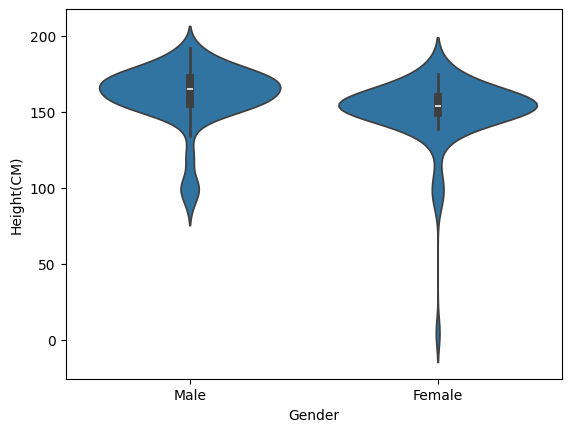

In [3]:
sns.violinplot(data=students, x="Gender", y="Height(CM)")

In [4]:
# we have some really wacky outliers as far as height goes, so we'll probably remove them so as to avoid
# their skewing the data

<Axes: xlabel='Gender', ylabel='Weight(KG)'>

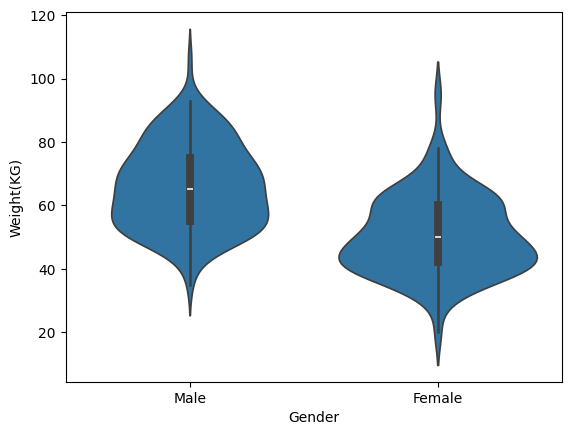

In [5]:
sns.violinplot(data=students, x="Gender", y="Weight(KG)")

In [6]:
# we also have some outliers in terms of weight, but it's less dramatic
# than with the height; nontheless, we'll remove those outliers

<Axes: xlabel='Gender', ylabel='10th Mark'>

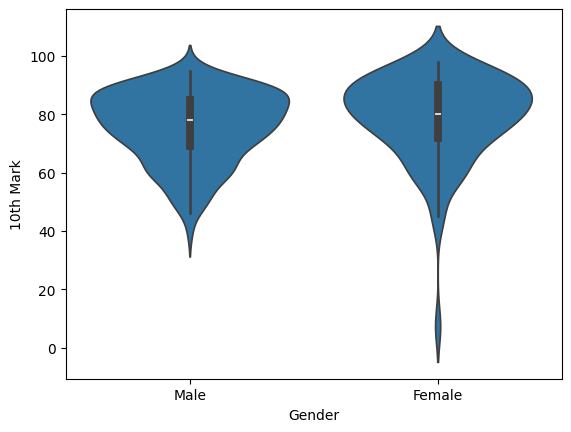

In [7]:
sns.violinplot(data=students, x="Gender", y="10th Mark")

<Axes: xlabel='Gender', ylabel='college mark'>

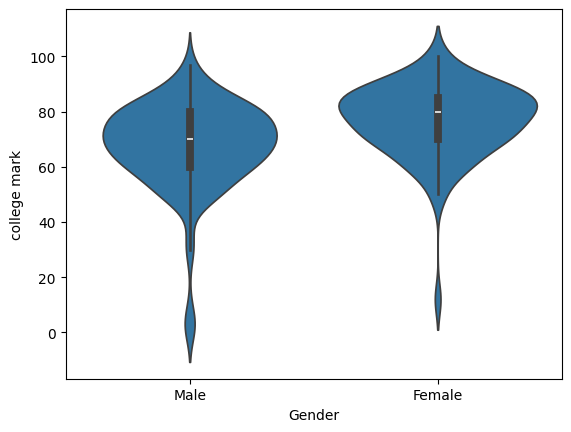

In [8]:
sns.violinplot(data=students, x="Gender", y="college mark")

<Axes: xlabel='Gender', ylabel='salary expectation'>

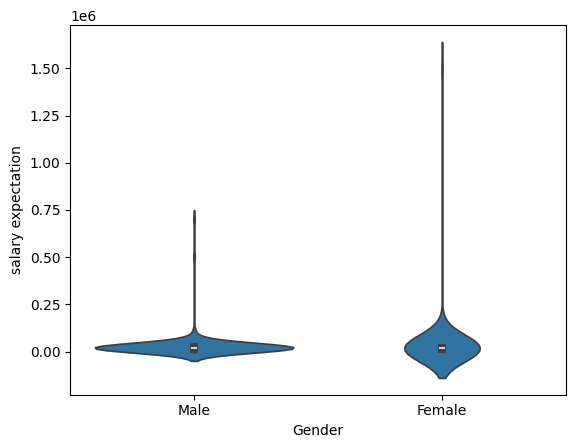

In [9]:
sns.violinplot(data=students, x="Gender", y="salary expectation")

<Axes: xlabel='Gender', ylabel='salary expectation'>

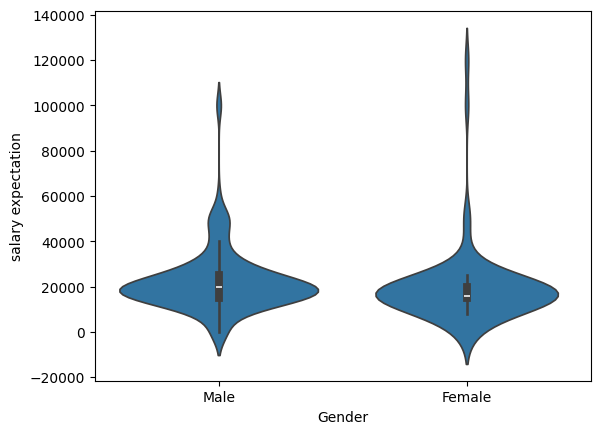

In [10]:
sns.violinplot(data=students[students["salary expectation"] < 500000], x="Gender", y="salary expectation")

In [11]:
students.shape

(235, 19)

In [12]:
# between the relatively low number of students and the number of outliers, we figure
# we'd likely be better off truncating the data (i.e. replacing high or low values)
# rather than removing them altogether

In [13]:
students.columns

Index(['Certification Course', 'Gender', 'Department', 'Height(CM)',
       'Weight(KG)', '10th Mark', '12th Mark', 'college mark', 'hobbies',
       'daily studing time', 'prefer to study in', 'salary expectation',
       'Do you like your degree?',
       'willingness to pursue a career based on their degree  ',
       'social medai & video', 'Travelling Time ', 'Stress Level ',
       'Financial Status', 'part-time job'],
      dtype='object')

In [14]:
# sorted([element for element in students['salary expectation']])
# with the height, there's only one student with a height so low
# that it's obviously an entry error, and it's also hard to correct,
# so we'll cut it out of the data
# we'll do the same for similar situations

students = students[students['Height(CM)'] > 4.5]
students = students[students['Weight(KG)'] > 20]

# we will also replace the very high value in the dataset to make it smoother
# - the observation will still be the highest

students.loc[students['Weight(KG)'] == 106.0, 'Weight(KG)'] = 100
students.loc[students['10th Mark'] == 7.4, '10th Mark'] = 39
students.loc[students['college mark'] < 30.0, 'college mark'] = 25
students.loc[students['salary expectation'] < 5000, 'salary expectation'] = 4500
students.loc[students['salary expectation'] > 60000.0, 'salary expectation'] = 65000

In [15]:
students.reset_index(drop=True, inplace=True)
students.shape
students.columns = [
    'certif', 'gender', 'department', 'height',
       'weight', '10_mark', '12_mark', 'college_mark', 'hobbies',
       'daily_studying_time', 'prefer_to_study_in', 'salary_expectation',
       'degree_affinity',
       'want_to_work_in_same_field',
       'social_med', 'travel_time ', 'stress',
       'financial_status', 'part_time_job'
]

In [16]:
students_scaled = students.copy()

list_of_columns_to_scale = [
    'height',
       'weight', '10_mark', '12_mark', 'college_mark', 'salary_expectation'
]

for column in list_of_columns_to_scale:
    min_of_column = min(students[column])
    max_of_column = max(students[column])
    
    students_scaled[column + "_scaled"] = (students[column] - min_of_column) / (max_of_column - min_of_column)
    
    
students_scaled.head(10)

,certif,gender,department,height,weight,10_mark,12_mark,college_mark,hobbies,daily_studying_time,...,travel_time,stress,financial_status,part_time_job,height_scaled,weight_scaled,10_mark_scaled,12_mark_scaled,college_mark_scaled,salary_expectation_scaled
0,No,Male,BCA,100.0,58.0,79.0,64.00,80.0,Video Games,0 - 30 minute,...,30 - 60 minutes,Bad,Bad,No,0.098039,0.382353,0.677966,0.387755,0.733333,0.586777
1,No,Female,BCA,90.0,40.0,70.0,80.00,70.0,Cinema,30 - 60 minute,...,0 - 30 minutes,Bad,Bad,No,0.000000,0.117647,0.525424,0.714286,0.600000,0.173554
2,Yes,Male,BCA,159.0,78.0,71.0,61.00,55.0,Cinema,1 - 2 Hour,...,30 - 60 minutes,Awful,Bad,No,0.676471,0.676471,0.542373,0.326531,0.400000,0.140496
3,No,Male,BCA,170.0,54.0,40.0,65.00,30.0,Video Games,30 - 60 minute,...,30 - 60 minutes,Good,good,No,0.784314,0.323529,0.016949,0.408163,0.066667,0.752066
4,Yes,Female,BCA,139.0,33.0,90.0,75.00,70.0,Cinema,30 - 60 minute,...,0 - 30 minutes,Bad,good,No,0.480392,0.014706,0.864407,0.612245,0.600000,0.256198
5,Yes,Male,BCA,165.0,50.0,70.0,63.00,25.0,Reading books,1 - 2 Hour,...,1 - 1.30 hour,Good,good,No,0.735294,0.264706,0.525424,0.367347,0.000000,0.173554
6,No,Male,BCA,152.0,43.0,61.6,61.67,75.0,Sports,1 - 2 Hour,...,1 - 1.30 hour,Good,good,No,0.607843,0.161765,0.383051,0.340204,0.666667,0.338843
7,No,Male,BCA,190.0,85.0,88.2,67.50,60.0,Video Games,0 - 30 minute,...,1 - 1.30 hour,Bad,Bad,No,0.980392,0.779412,0.833898,0.459184,0.466667,0.256198
8,No,Male,BCA,150.0,84.0,60.0,65.00,70.0,Video Games,0 - 30 minute,...,30 - 60 minutes,Good,good,No,0.588235,0.764706,0.355932,0.408163,0.600000,0.256198
9,No,Male,BCA,99.0,50.0,75.0,70.00,60.0,Video Games,1 - 2 Hour,...,0 - 30 minutes,Good,Bad,No,0.088235,0.264706,0.610169,0.510204,0.466667,0.223140


In [17]:

le = LabelEncoder()

columns_to_encode = [
     'certif', 'gender', 'department', 'hobbies',
       'daily_studying_time', 'prefer_to_study_in',
       'degree_affinity',
       'want_to_work_in_same_field',
       'social_med', 'travel_time ', 'stress',
       'financial_status', 'part_time_job'
]

for column in columns_to_encode:
    students_scaled[column + '_encoded'] = le.fit_transform(students_scaled[column])
    students_scaled.drop(columns=[column], inplace=True)

students_scaled.head(5)

,height,weight,10_mark,12_mark,college_mark,salary_expectation,height_scaled,weight_scaled,10_mark_scaled,12_mark_scaled,...,hobbies_encoded,daily_studying_time_encoded,prefer_to_study_in_encoded,degree_affinity_encoded,want_to_work_in_same_field_encoded,social_med_encoded,travel_time _encoded,stress_encoded,financial_status_encoded,part_time_job_encoded
0,100.0,58.0,79.0,64.0,80.0,40000,0.098039,0.382353,0.677966,0.387755,...,3,0,1,0,3,3,5,1,1,0
1,90.0,40.0,70.0,80.0,70.0,15000,0.000000,0.117647,0.525424,0.714286,...,0,4,1,1,4,1,0,1,1,0
2,159.0,78.0,71.0,61.0,55.0,13000,0.676471,0.676471,0.542373,0.326531,...,0,1,0,1,3,5,5,0,1,0
3,170.0,54.0,40.0,65.0,30.0,50000,0.784314,0.323529,0.016949,0.408163,...,3,4,1,1,2,3,5,2,3,0
4,139.0,33.0,90.0,75.0,70.0,20000,0.480392,0.014706,0.864407,0.612245,...,0,4,2,1,3,4,0,1,3,0


In [18]:
# the dataset seems to be ready for clustering,
# so we'll also create a copy and center the continuous variables in it to prep it for PCA
students_scaled_centered = students_scaled.copy()

columns_to_center = [col_name + "_scaled" for col_name in list_of_columns_to_scale]

for column in columns_to_center:
    students_scaled_centered[column + "_and_centered"] = (
        students_scaled_centered[column] - students_scaled_centered[column].mean())

students_scaled_centered.drop(columns=columns_to_center, inplace=True)
students_scaled_centered.drop(columns=list_of_columns_to_scale, inplace=True)

students_scaled_centered.head(10)

,certif_encoded,gender_encoded,department_encoded,hobbies_encoded,daily_studying_time_encoded,prefer_to_study_in_encoded,degree_affinity_encoded,want_to_work_in_same_field_encoded,social_med_encoded,travel_time _encoded,stress_encoded,financial_status_encoded,part_time_job_encoded,height_scaled_and_centered,weight_scaled_and_centered,10_mark_scaled_and_centered,12_mark_scaled_and_centered,college_mark_scaled_and_centered,salary_expectation_scaled_and_centered
0,0,1,2,3,0,1,0,3,3,5,1,1,0,-0.569637,-0.044616,0.034262,-0.096464,0.118928,0.311921
1,0,0,2,0,4,1,1,4,1,0,1,1,0,-0.667677,-0.309322,-0.118280,0.230067,-0.014405,-0.101302
2,1,1,2,0,1,0,1,3,5,5,0,1,0,0.008794,0.249501,-0.101331,-0.157689,-0.214405,-0.134360
3,0,1,2,3,4,1,1,2,3,5,2,3,0,0.116637,-0.103440,-0.626755,-0.076056,-0.547738,0.477211
4,1,0,2,0,4,2,1,3,4,0,1,3,0,-0.187284,-0.412263,0.220703,0.128026,-0.014405,-0.018657
5,1,1,2,1,1,1,1,4,1,1,2,3,0,0.067618,-0.162263,-0.118280,-0.116872,-0.614405,-0.101302
6,0,1,2,2,1,1,1,3,1,1,2,3,0,-0.059833,-0.265204,-0.260653,-0.144015,0.052262,0.063988
7,0,1,2,3,0,1,1,4,3,1,1,1,0,0.312716,0.352443,0.190194,-0.025035,-0.147738,-0.018657
8,0,1,2,3,0,0,1,4,4,5,2,3,0,-0.079441,0.337737,-0.287772,-0.076056,-0.014405,-0.018657
9,0,1,2,3,1,1,1,4,1,0,2,1,0,-0.579441,-0.162263,-0.033535,0.025985,-0.147738,-0.051715


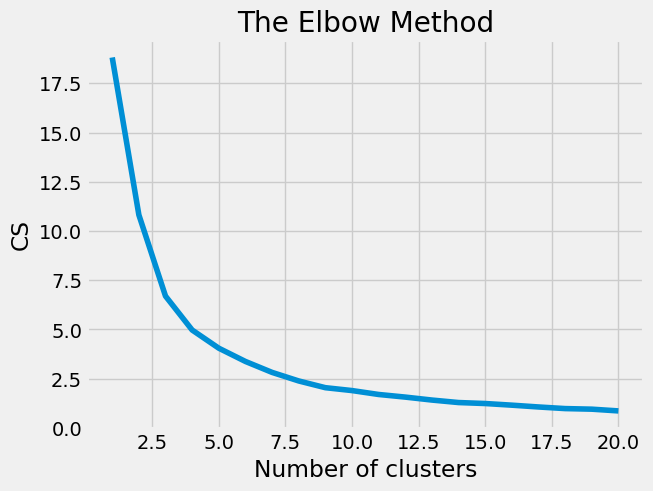

In [28]:
student_fitness = students_scaled_centered[['height_scaled_and_centered', 'weight_scaled_and_centered']]

cs = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(student_fitness)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 21), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [29]:
# there is no obvious number of clusters that we can read from the graph (maybe 2 is a candidate?)
# but we'll also apply the knee locator, and then the sillhouette score method to be sure
kl = KneeLocator(
    range(1, 21), cs, curve="convex", direction="decreasing"
)

kl.elbow

4

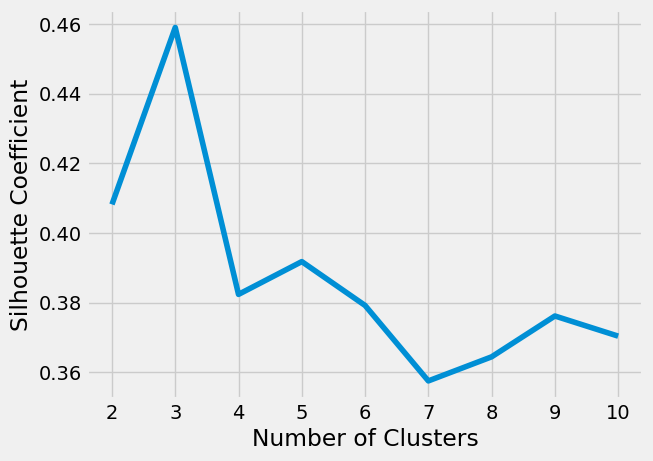

In [31]:
# sillhouette score

kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
}

silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(student_fitness)
    score = silhouette_score(student_fitness, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [ ]:
# it looks like we have 3 clusters!

In [26]:
# we found this https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# while looking for ways to determine the right number of clusters, so we'll use it
# to plot the various clusters and check what they look like
import matplotlib.cm as cm

from sklearn.metrics import silhouette_samples

For n_clusters = 2 The average silhouette_score is : 0.40871000388208467
For n_clusters = 3 The average silhouette_score is : 0.3268607126232685
For n_clusters = 4 The average silhouette_score is : 0.38240723119644027
For n_clusters = 5 The average silhouette_score is : 0.37499109706157113
For n_clusters = 6 The average silhouette_score is : 0.34956376270113726
For n_clusters = 7 The average silhouette_score is : 0.34205721404049816
For n_clusters = 8 The average silhouette_score is : 0.35719550381344956
For n_clusters = 9 The average silhouette_score is : 0.36483787013164887
For n_clusters = 10 The average silhouette_score is : 0.3615390671840662
For n_clusters = 11 The average silhouette_score is : 0.3586023274739681
For n_clusters = 12 The average silhouette_score is : 0.3587597351360858


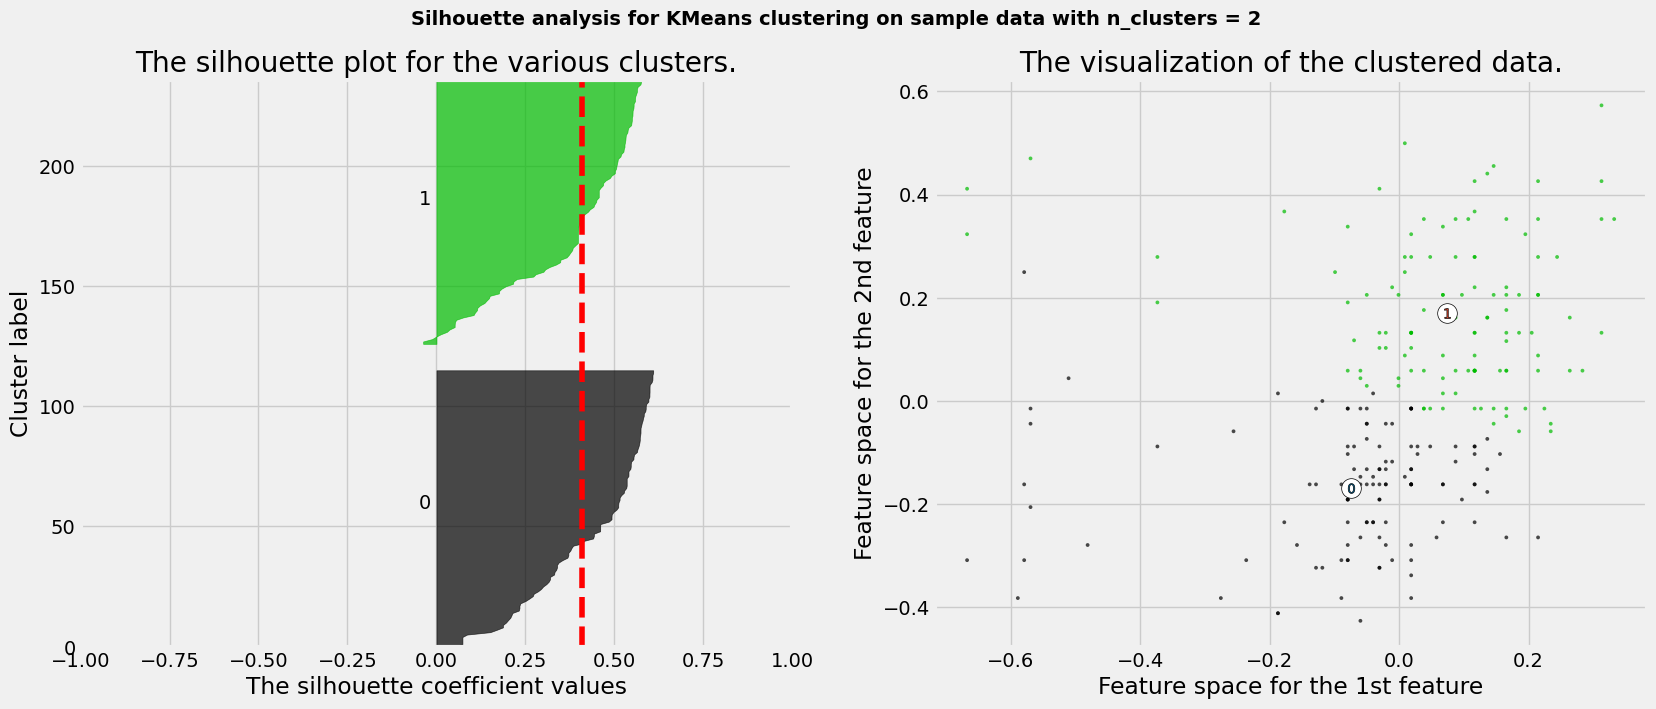

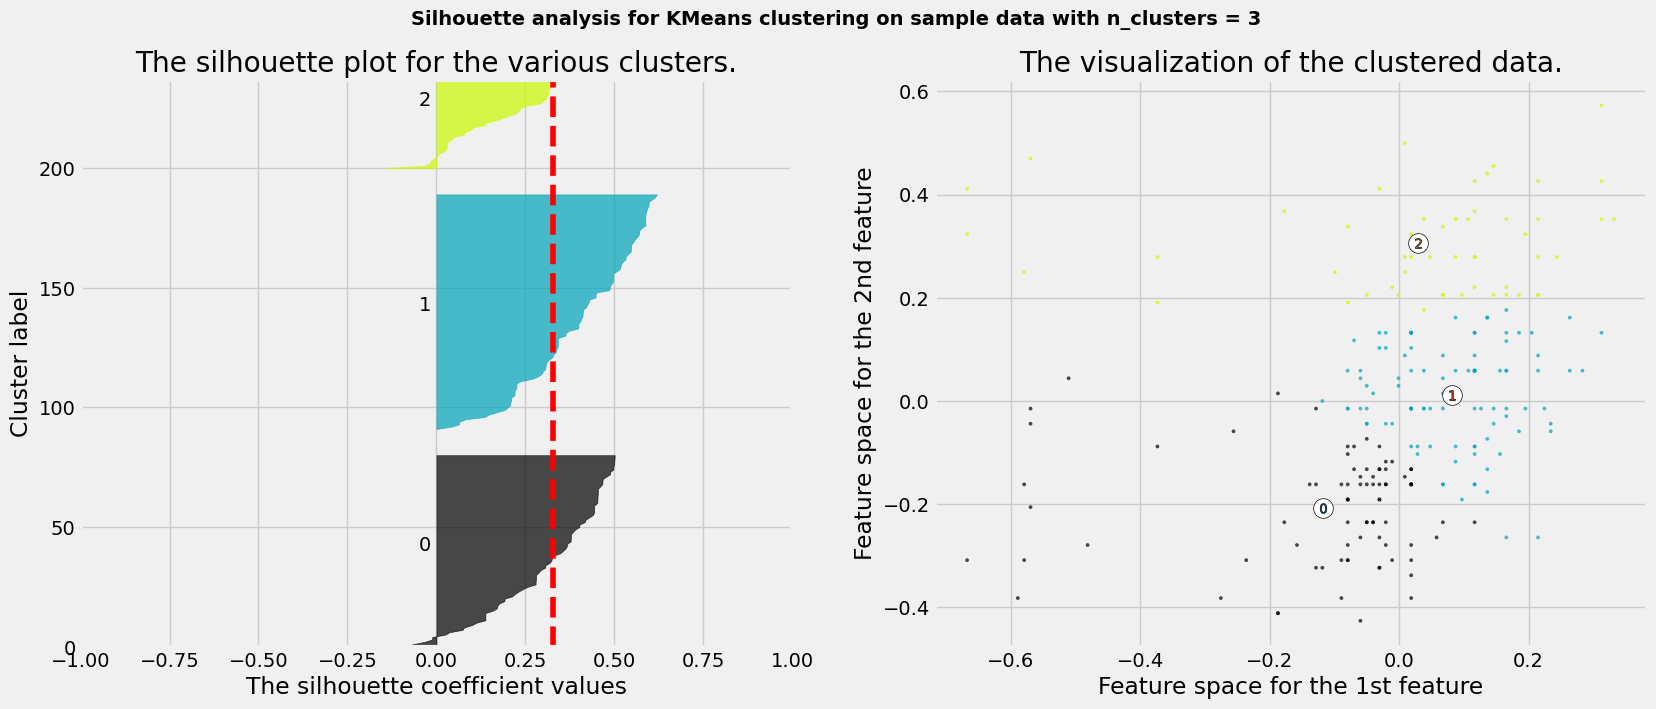

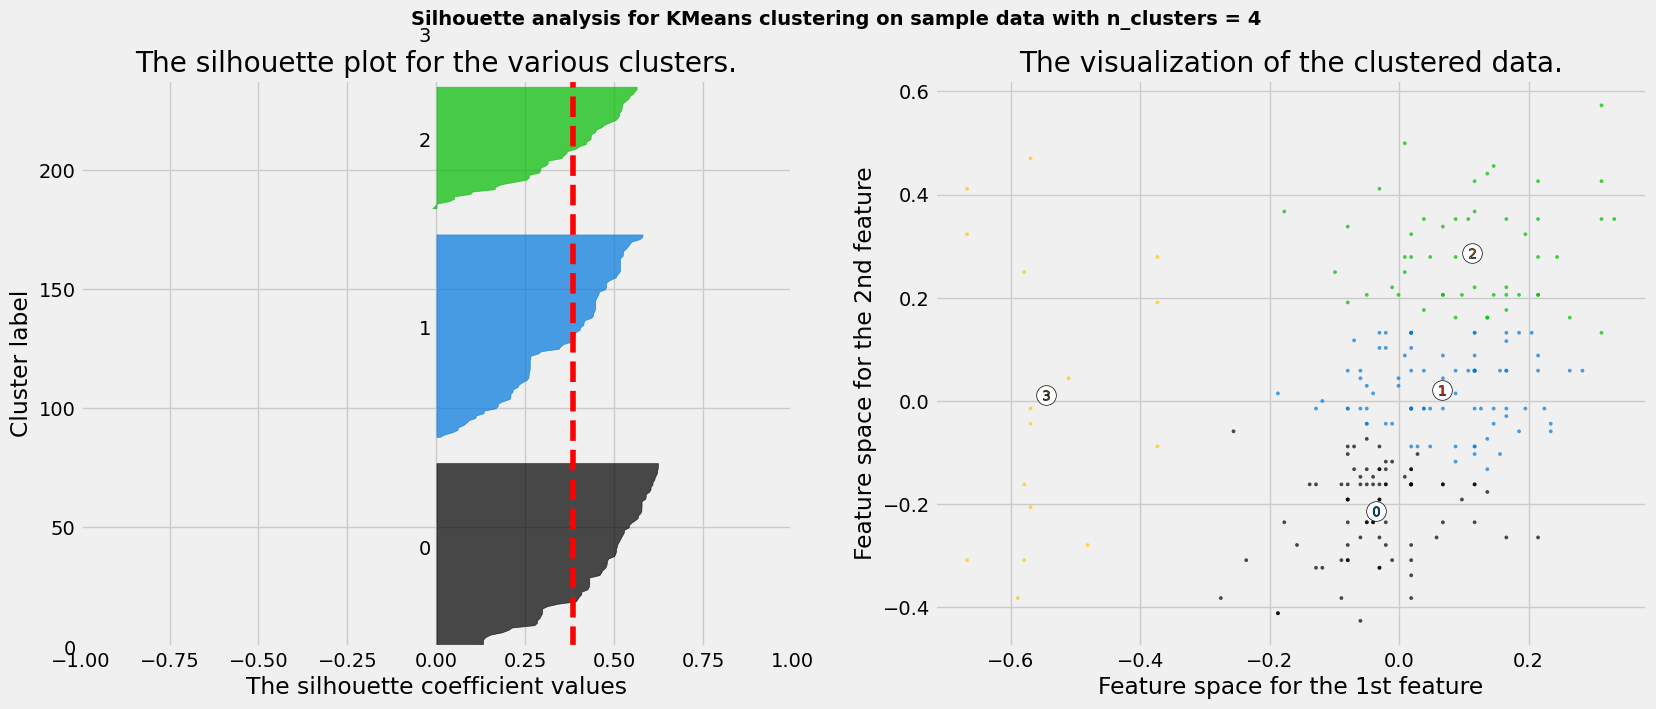

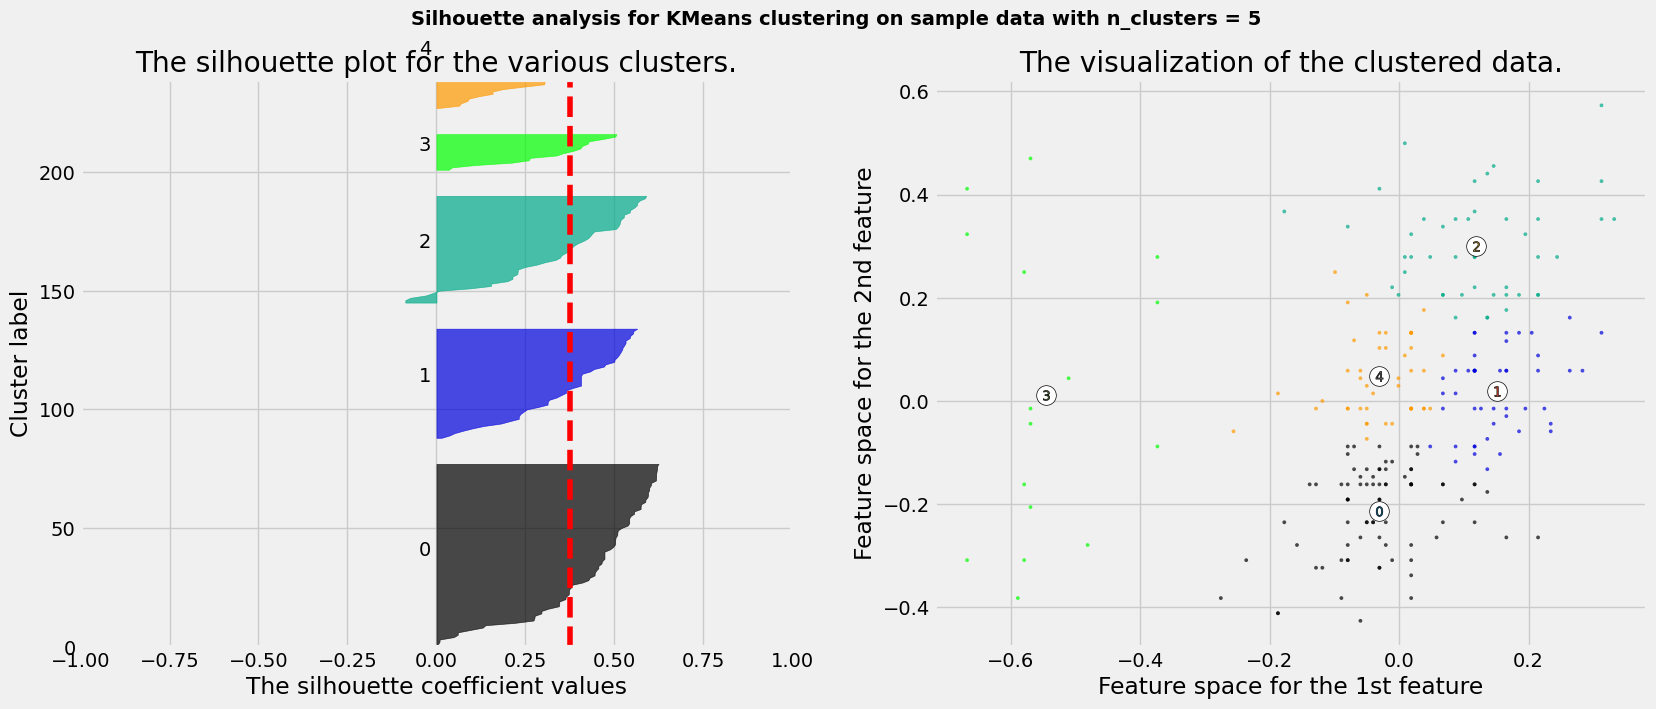

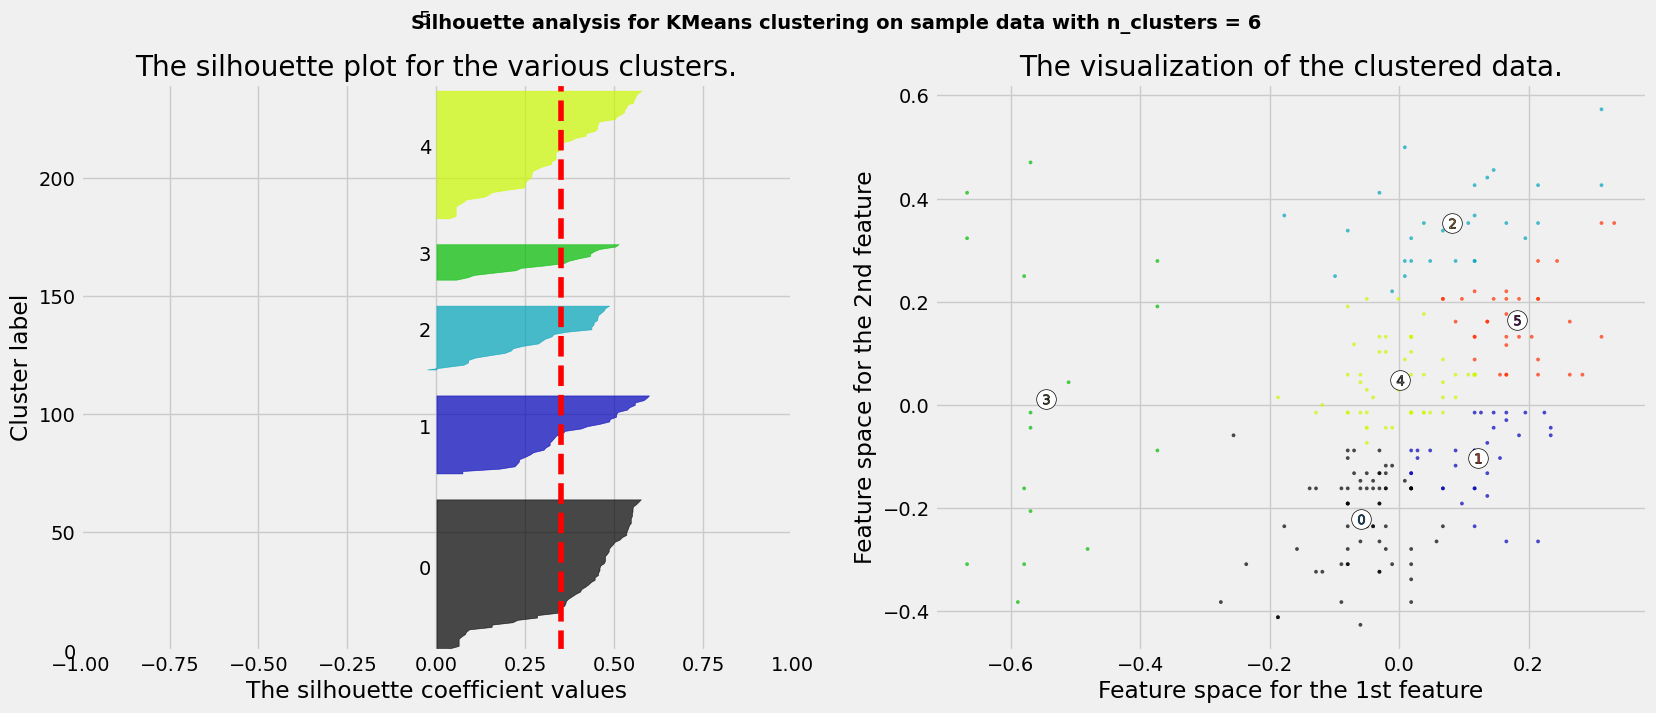

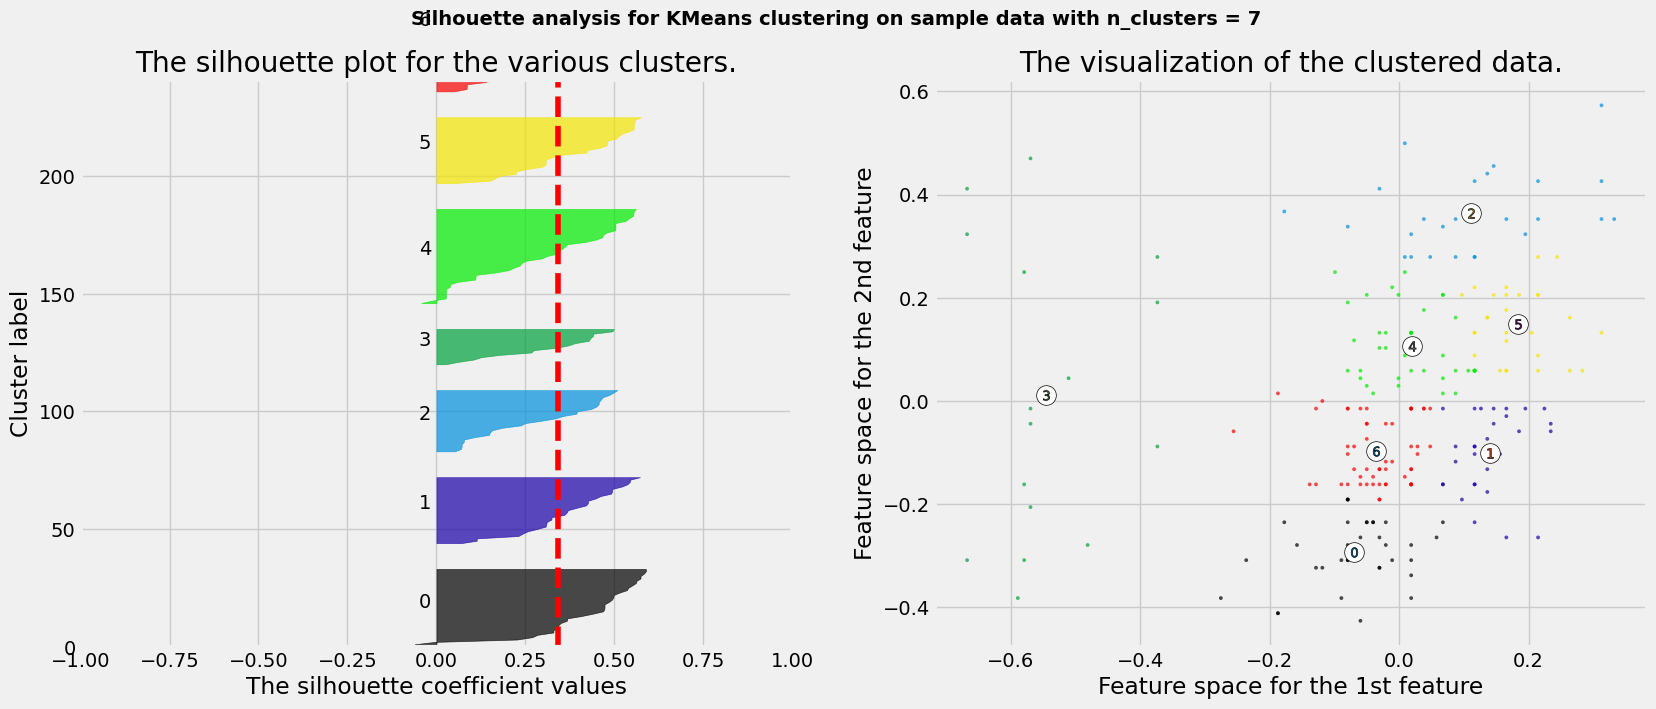

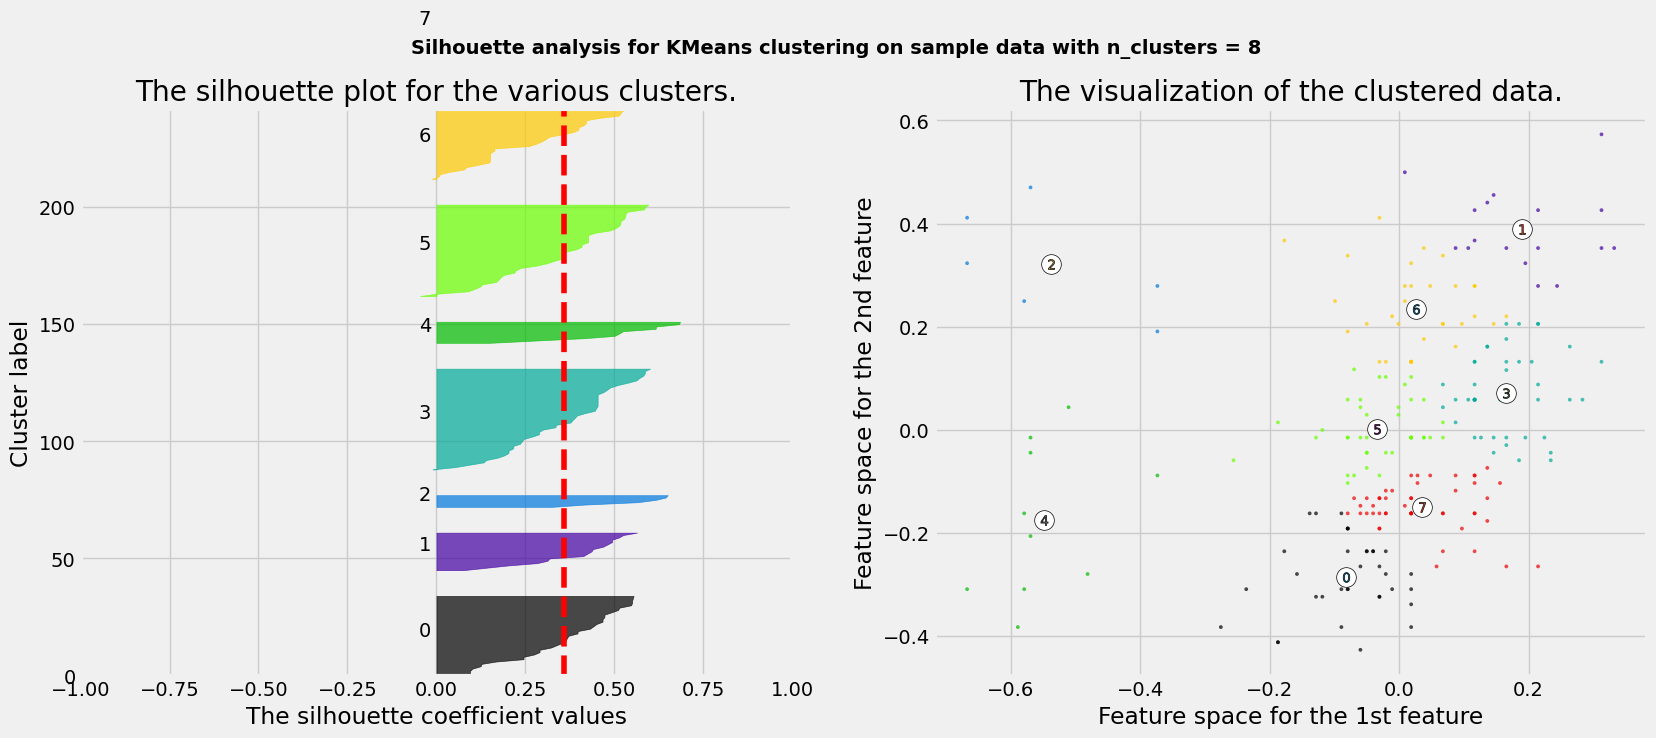

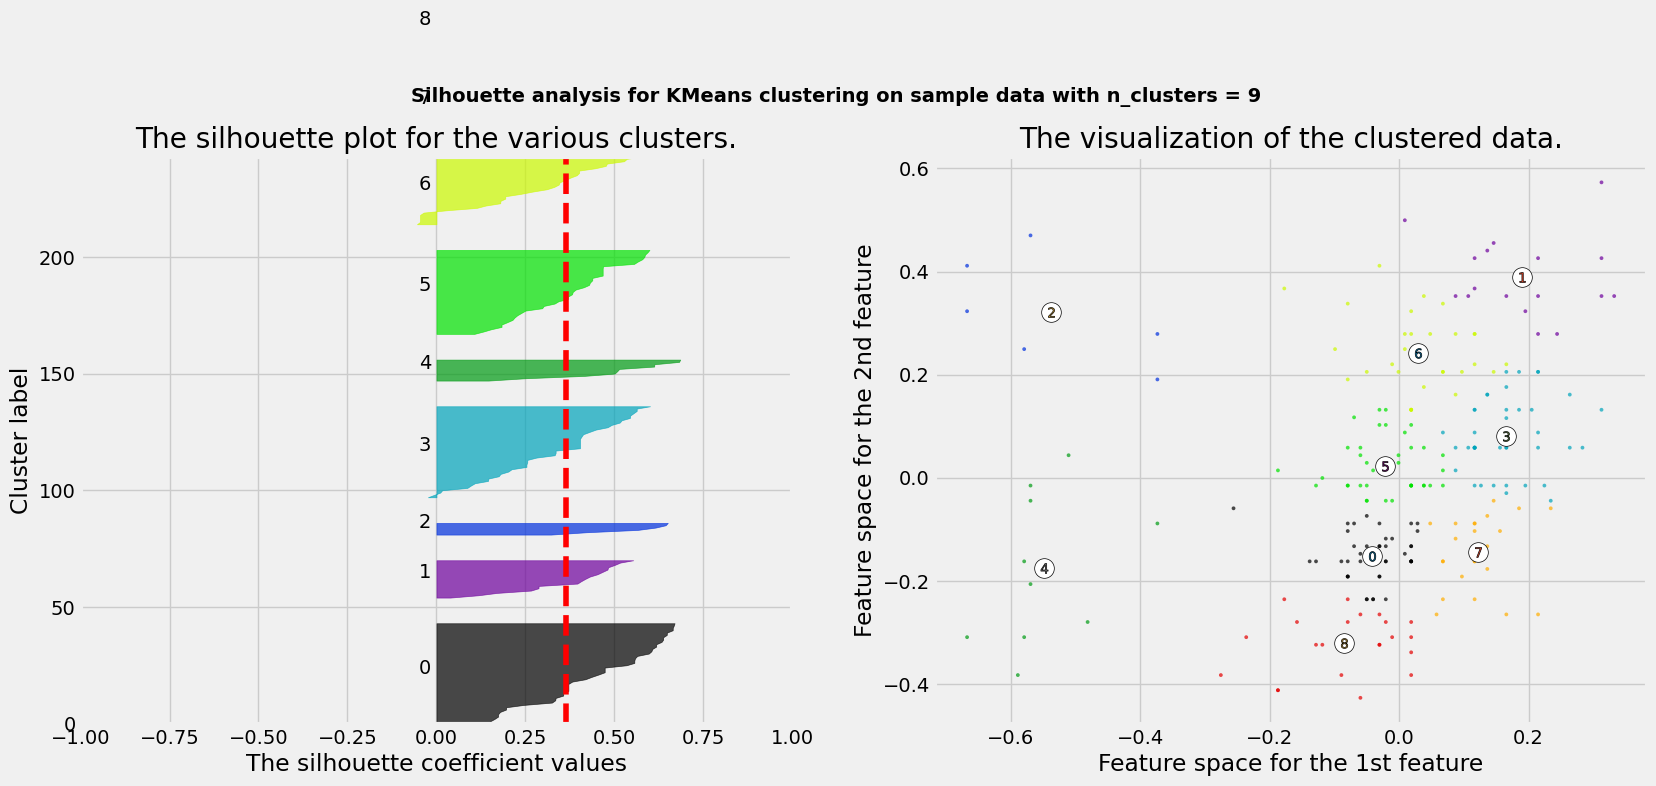

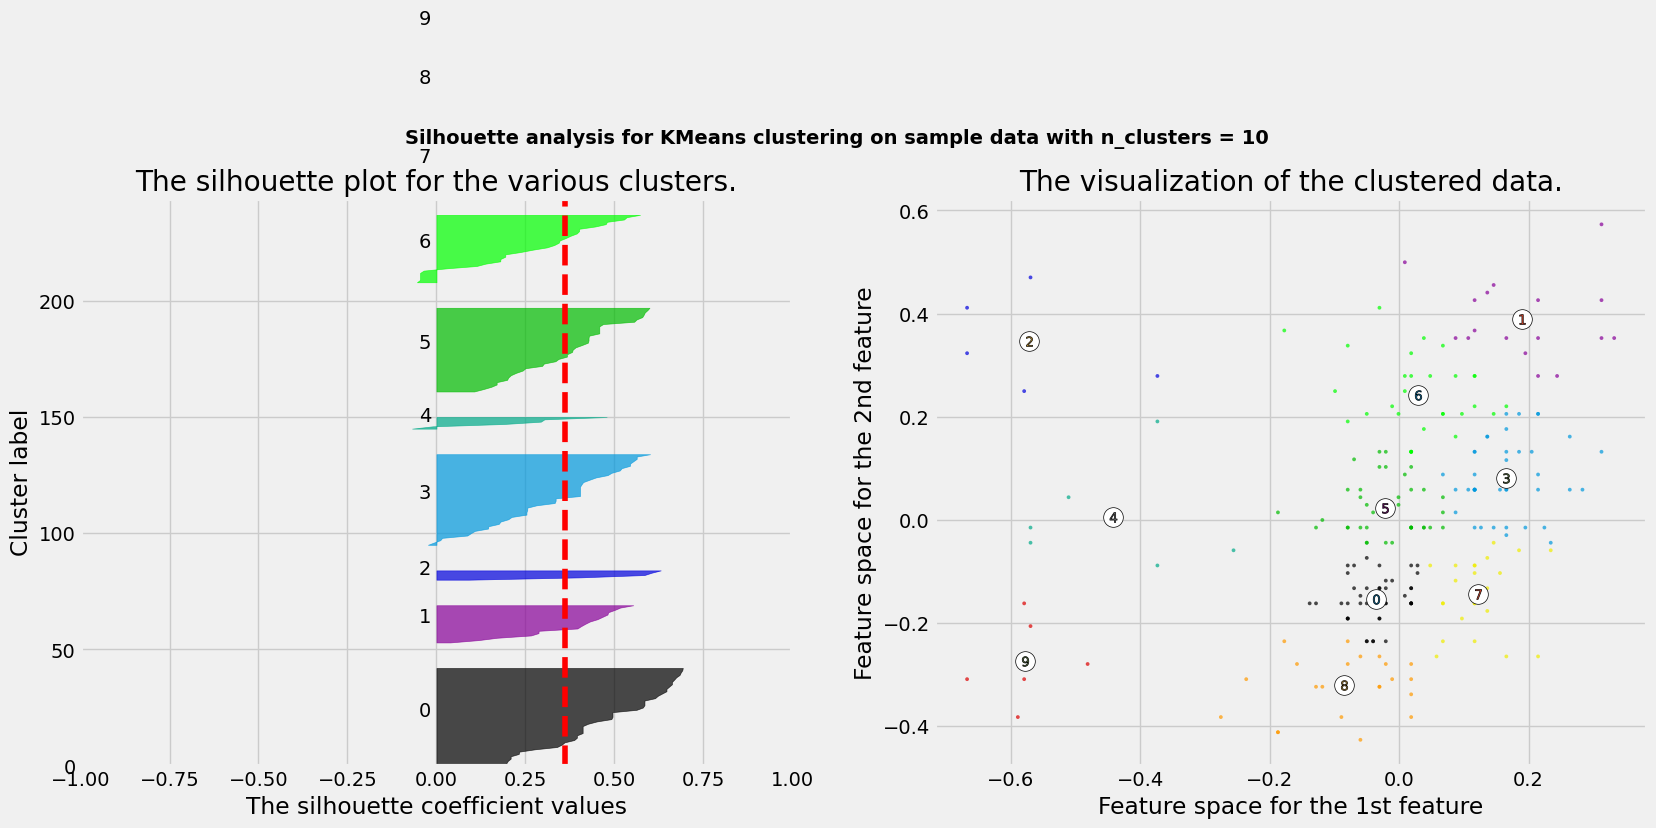

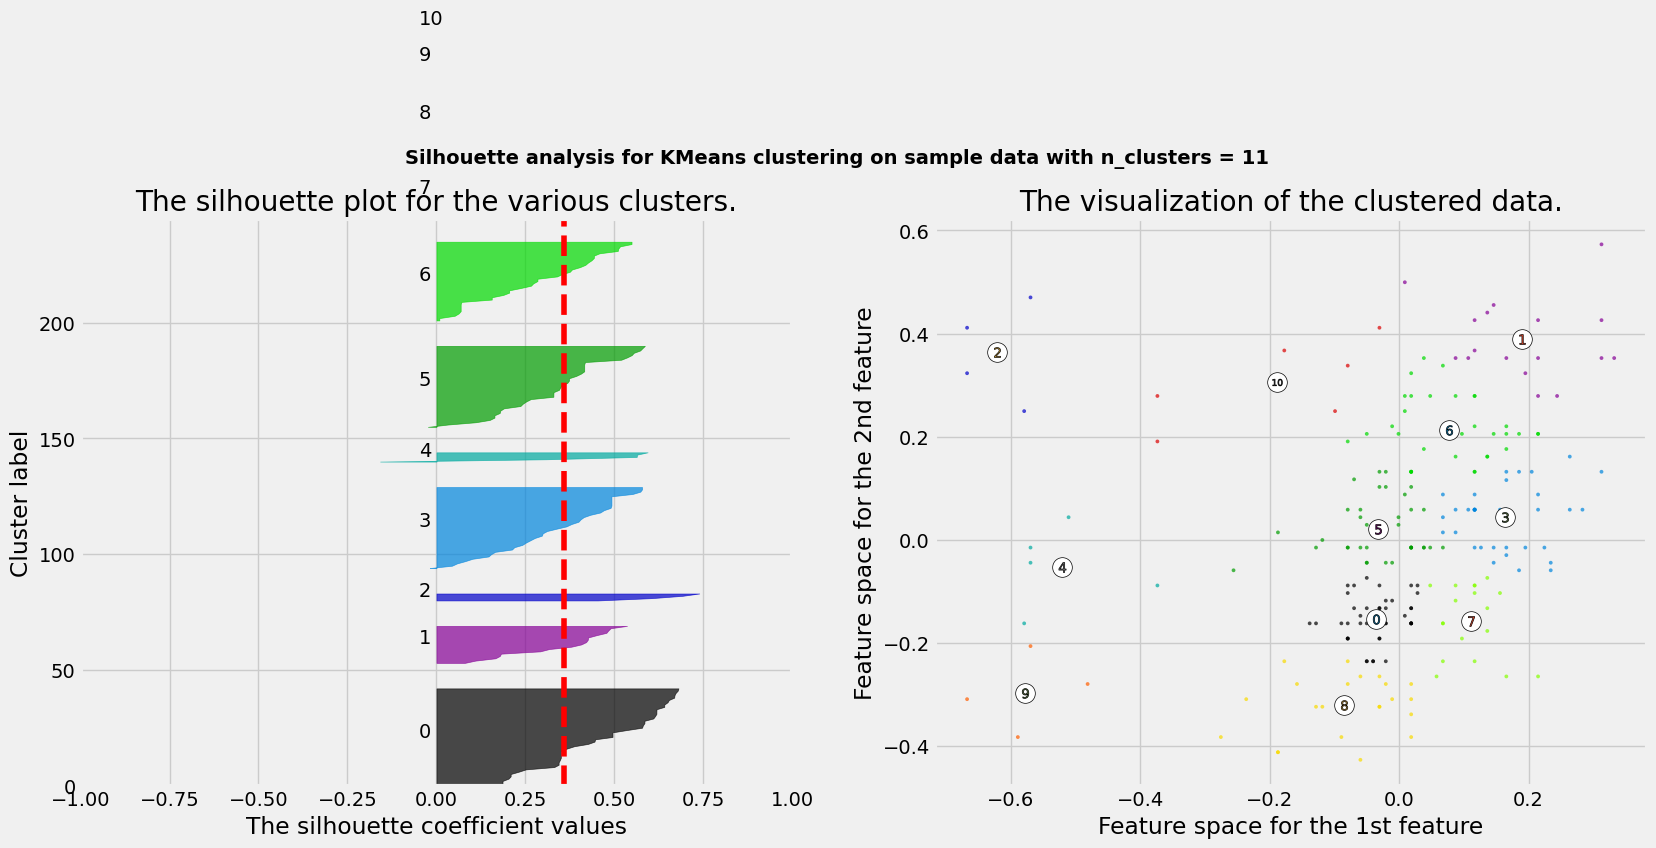

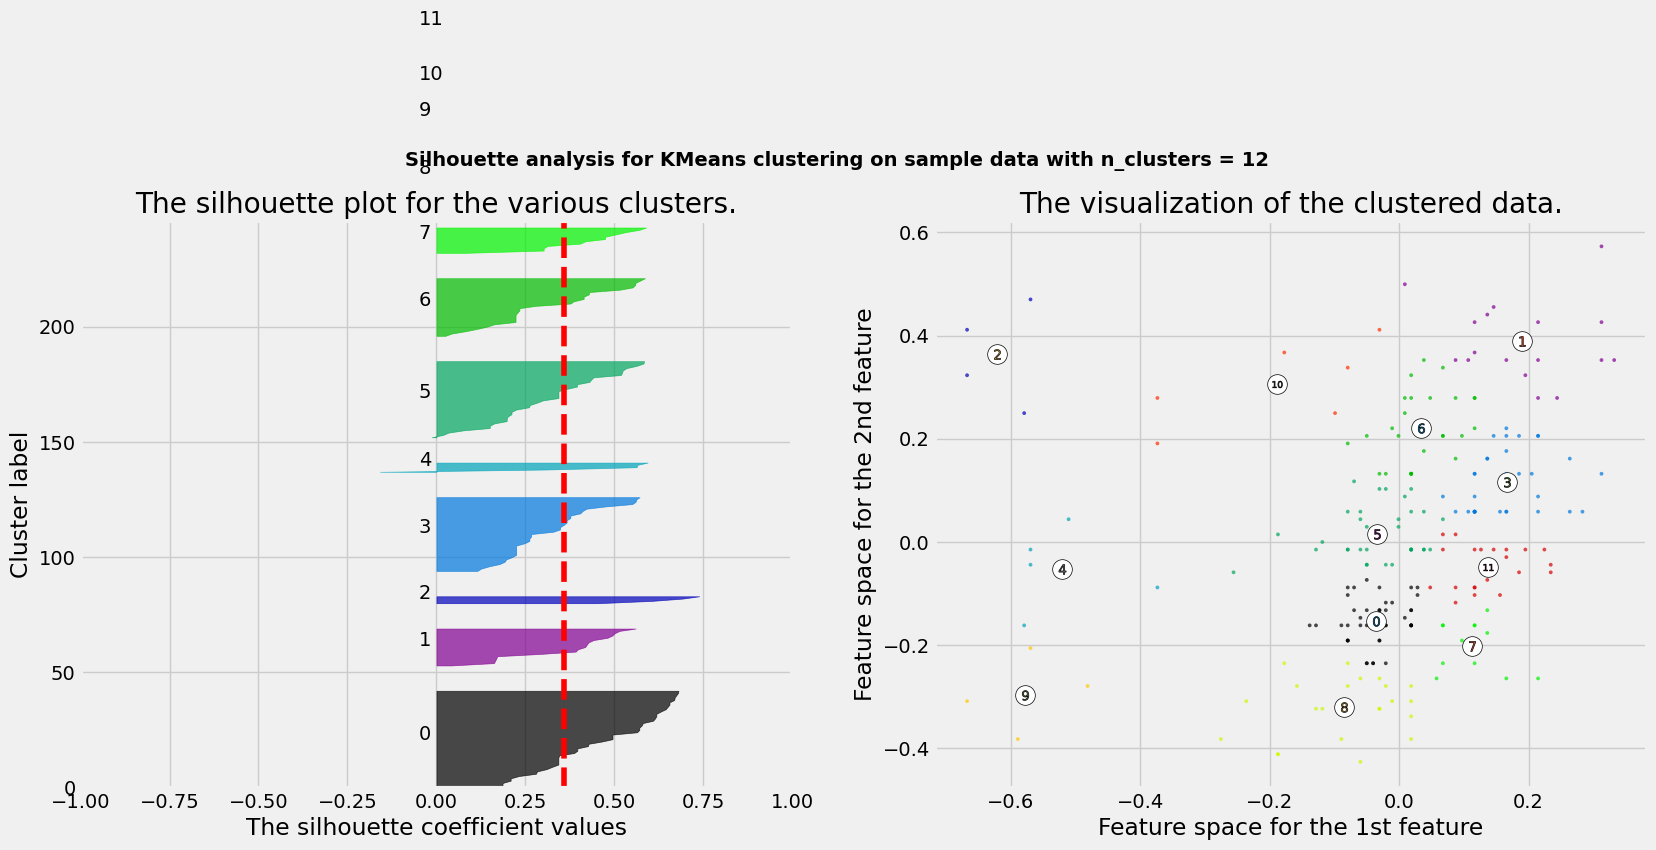

In [33]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(student_fitness) + (n_clusters + 1) * 1])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(student_fitness)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(student_fitness, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(student_fitness, cluster_labels)

    y_lower = -1
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    #ax1.set_yticks([])  # Clear the yaxis labels / ticks
    #ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        student_fitness.iloc[:, 0], student_fitness.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [36]:
# none of the clustrering techniques seem to have produced convincing results;
# what about PCA?

pca = PCA()

pca.fit(students_scaled_centered)
print(pca.explained_variance_ratio_)

[0.31156039 0.16110716 0.13314685 0.09132354 0.07306972 0.07270127
 0.03995457 0.03642017 0.02849903 0.01398572 0.01321516 0.00829482
 0.00433363 0.00413381 0.00235188 0.00201559 0.00161849 0.00125754
 0.00101065]


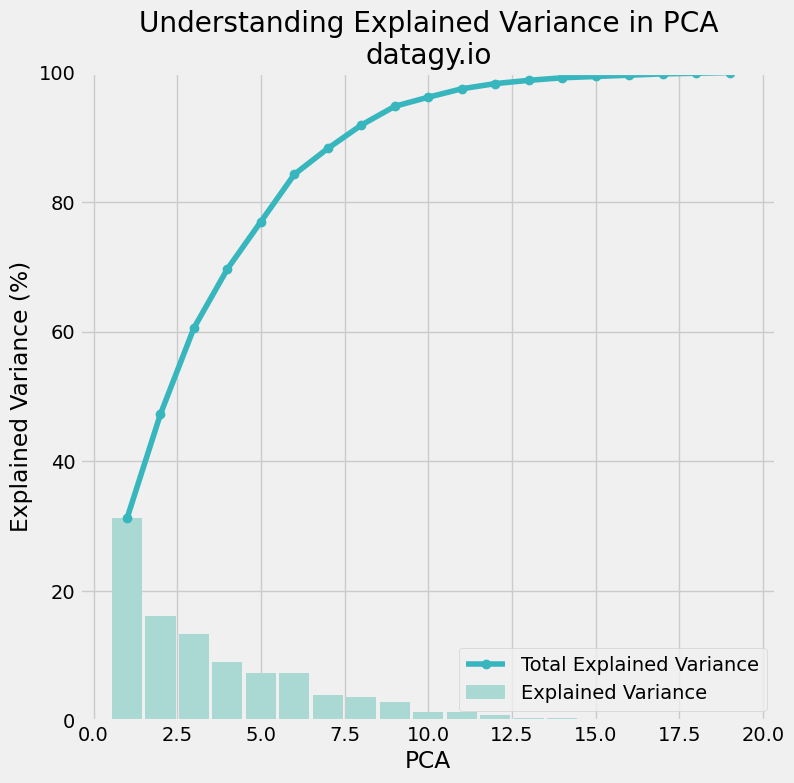

In [37]:
expl_var = pca.explained_variance_ratio_
df_expl_var = pd.DataFrame(
    data=zip(range(1, len(expl_var) + 1), expl_var, expl_var.cumsum()), 
    columns=['PCA', 'Explained Variance (%)', 'Total Explained Variance (%)']
    ).set_index('PCA').mul(100).round(1)

fig, ax = plt.subplots(figsize=(8,8))
ax.bar(x=df_expl_var.index, height=df_expl_var['Explained Variance (%)'], label='Explained Variance', width=0.9, color='#AAD8D3')
ax.plot(df_expl_var['Total Explained Variance (%)'], label='Total Explained Variance', marker='o', c='#37B6BD')

plt.ylim(0, 100)
plt.ylabel('Explained Variance (%)')
plt.xlabel('PCA')
plt.grid(True, axis='y')
plt.title('Understanding Explained Variance in PCA\ndatagy.io')
plt.legend()

In [39]:
# with 5 or 6 components we can explain ~ 80% of the variance

# 3 components cover 60%, so we'll also check those out


pca_5 = PCA(5)
pca_6 = PCA(6)


students_pca_5 = pca_5.fit_transform(students_scaled_centered)
students_pca_6 = pca_6.fit_transform(students_scaled_centered)

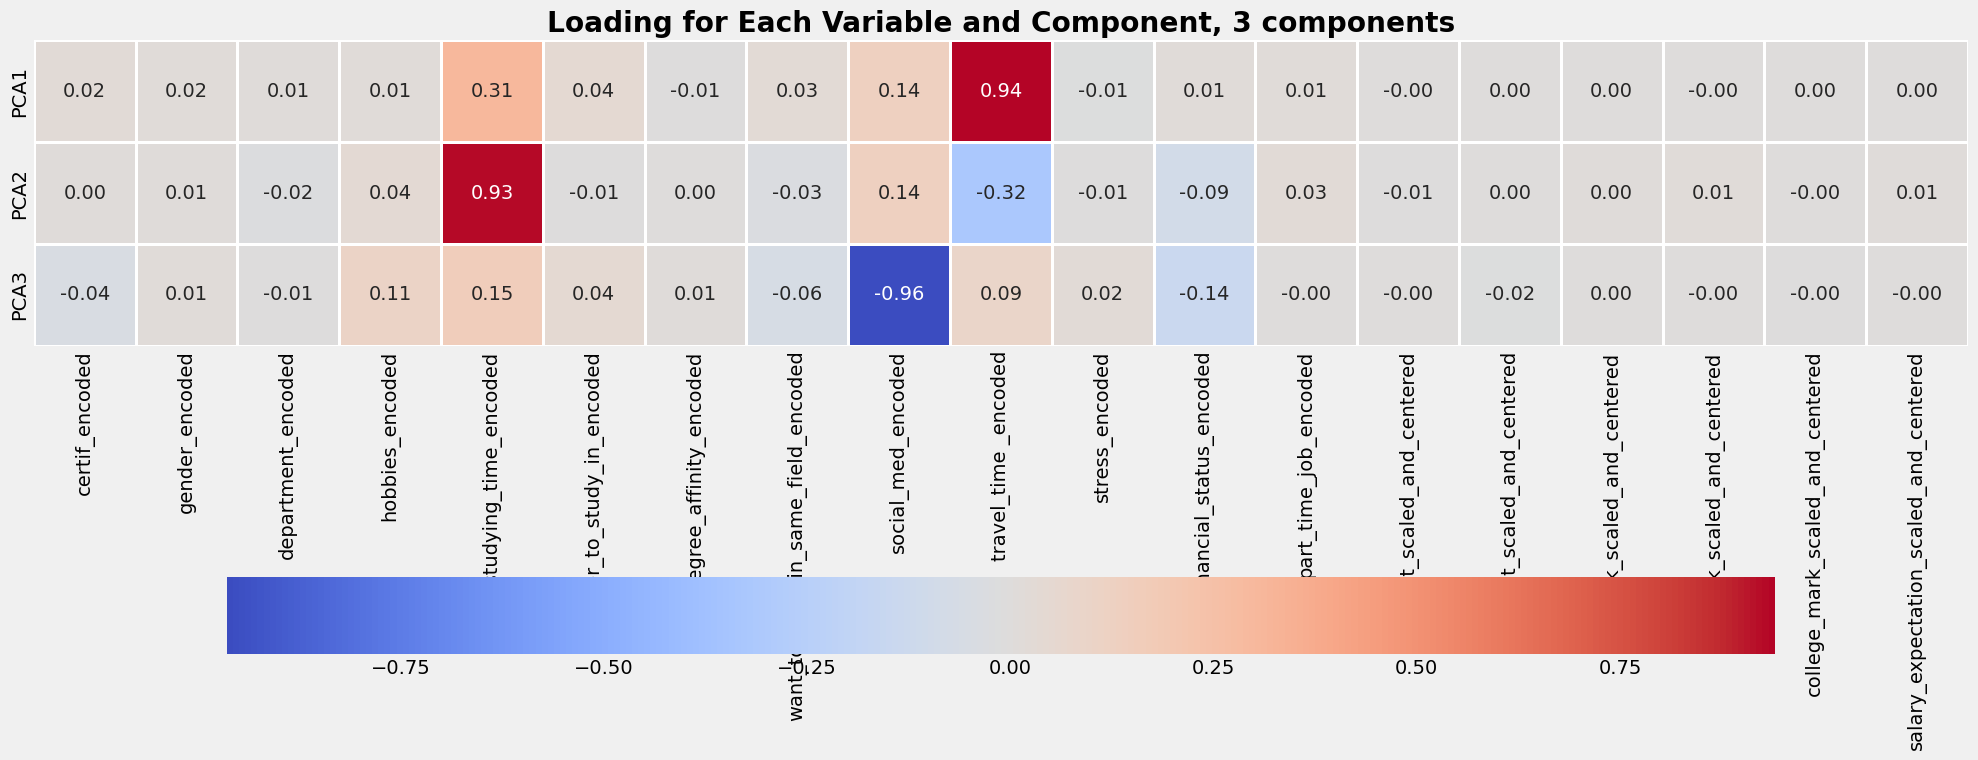

In [45]:
pca_3 = PCA(3)

students_pca_3 = pca_3.fit_transform(students_scaled_centered)

fig, ax = plt.subplots(figsize=(20,16))

ax = sns.heatmap(
    pca_3.components_,
    cmap='coolwarm',
    yticklabels=[f'PCA{x}' for x in range(1,pca_3.n_components_+1)],
    xticklabels=list(students_scaled_centered.columns),
    linewidths=1,
    annot=True,
    fmt=',.2f',
    cbar_kws={"shrink": 0.8, "orientation": 'horizontal'}
    )

fig.tight_layout()
ax.set_aspect("equal")
plt.title('Loading for Each Variable and Component, 3 components', weight='bold')
plt.show()

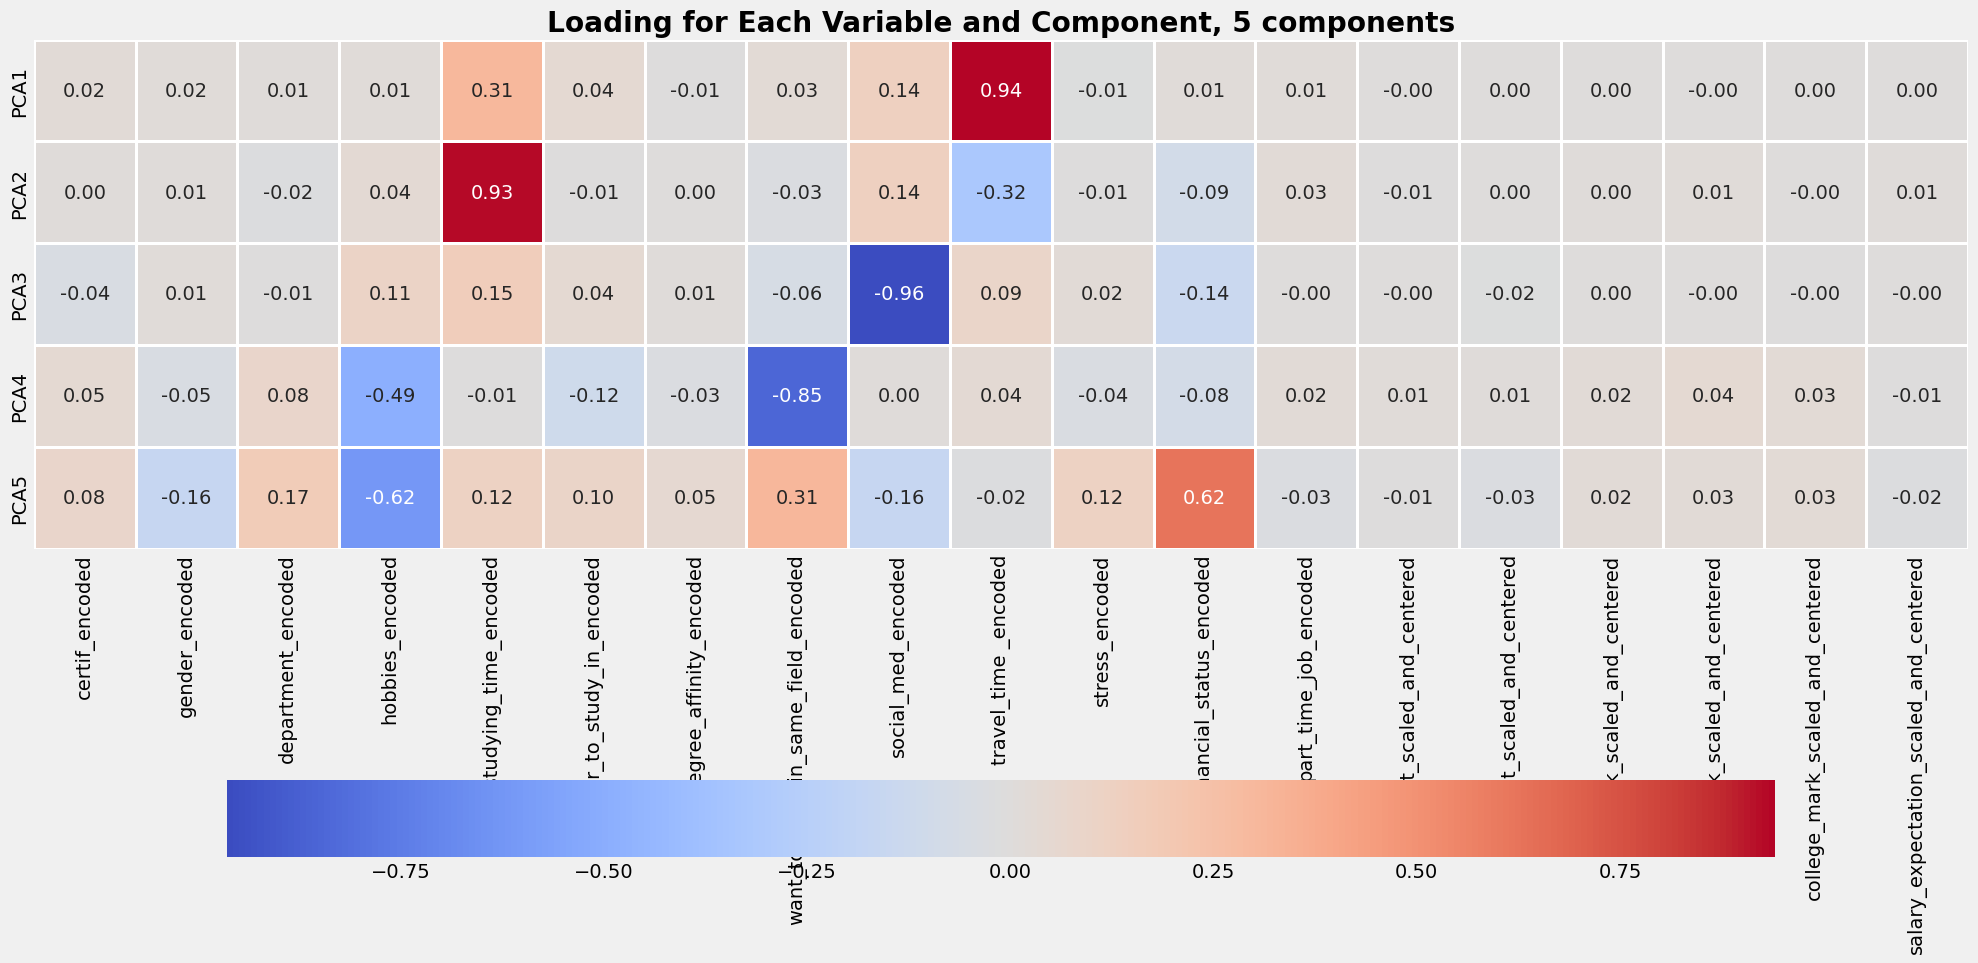

In [46]:
students_pca_5 = pca_5.fit_transform(students_scaled_centered)

fig, ax = plt.subplots(figsize=(20,16))

ax = sns.heatmap(
    pca_5.components_,
    cmap='coolwarm',
    yticklabels=[f'PCA{x}' for x in range(1,pca_5.n_components_+1)],
    xticklabels=list(students_scaled_centered.columns),
    linewidths=1,
    annot=True,
    fmt=',.2f',
    cbar_kws={"shrink": 0.8, "orientation": 'horizontal'}
    )

fig.tight_layout()
ax.set_aspect("equal")
plt.title('Loading for Each Variable and Component, 5 components', weight='bold')
plt.show()

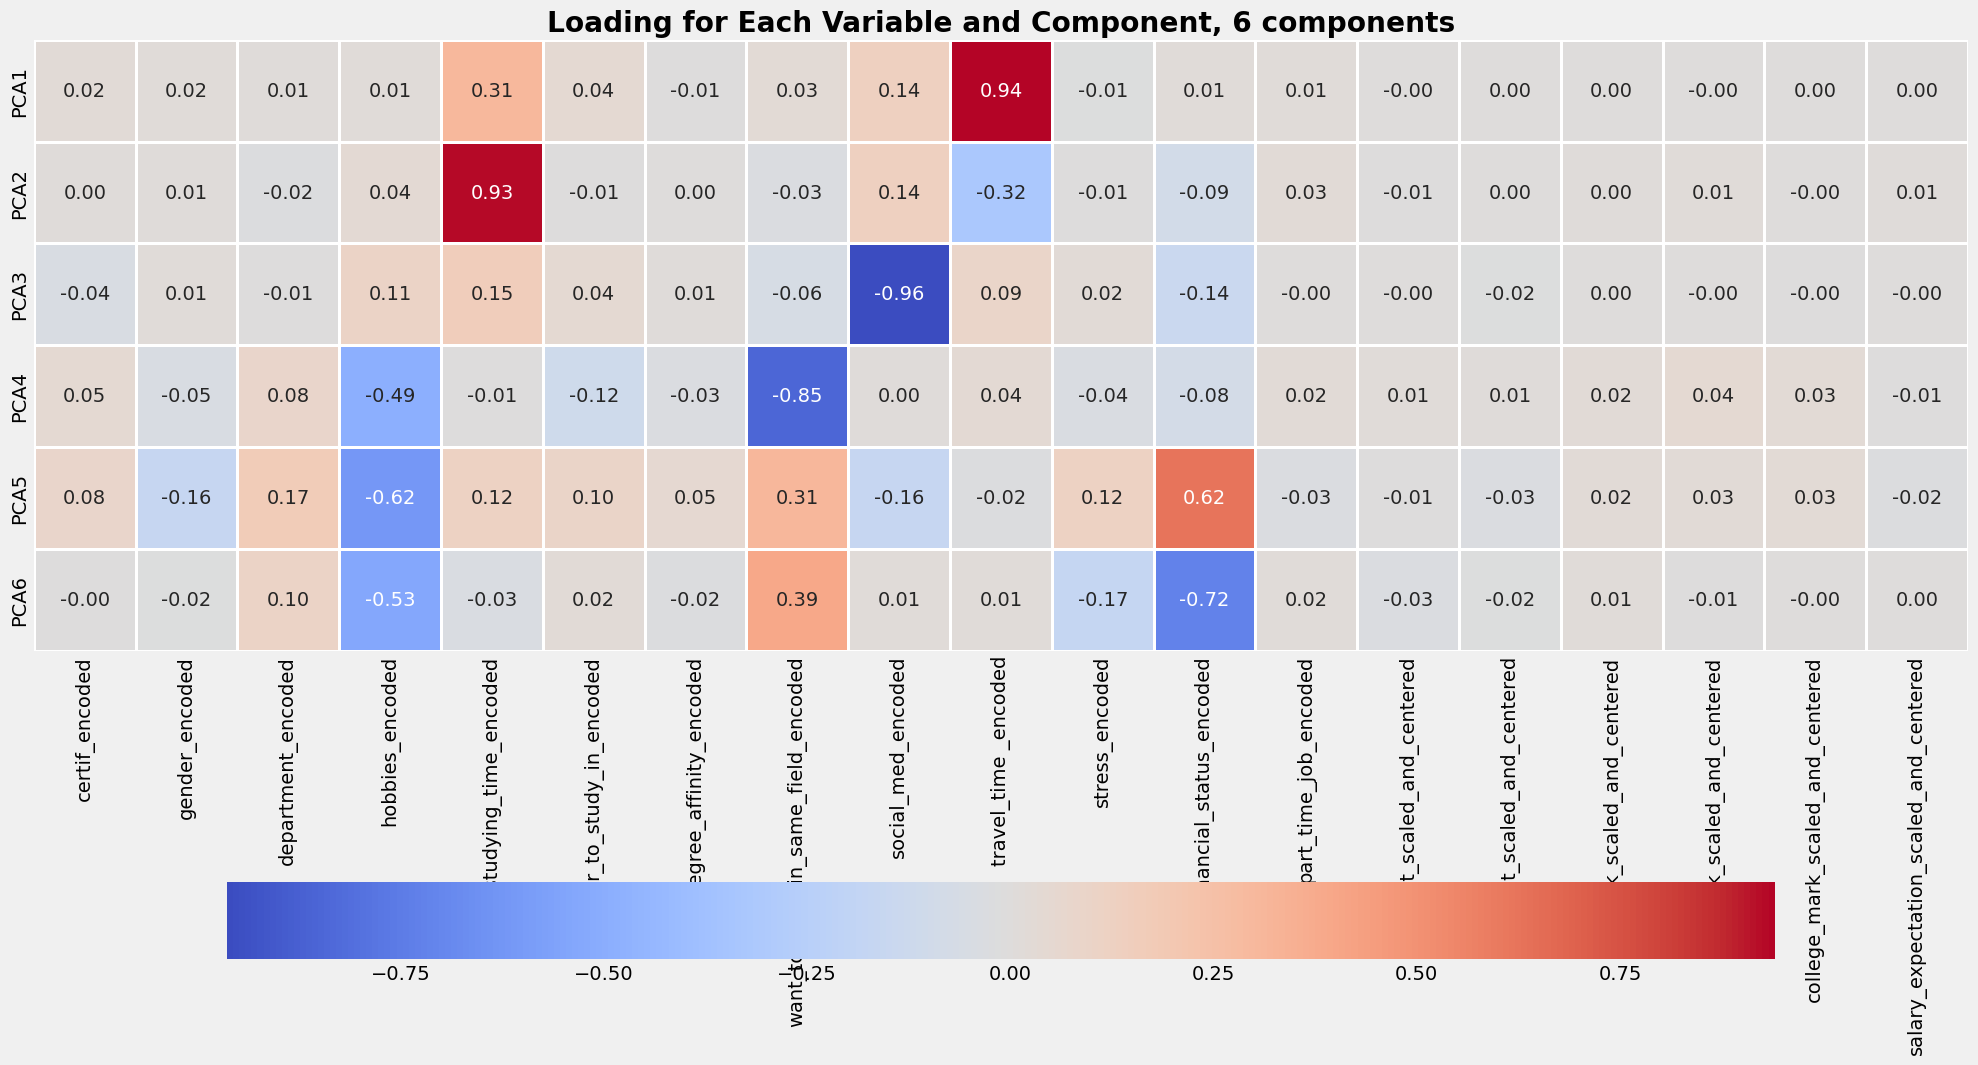

In [47]:
students_pca_6 = pca_6.fit_transform(students_scaled_centered)

fig, ax = plt.subplots(figsize=(20,16))

ax = sns.heatmap(
    pca_6.components_,
    cmap='coolwarm',
    yticklabels=[f'PCA{x}' for x in range(1,pca_6.n_components_+1)],
    xticklabels=list(students_scaled_centered.columns),
    linewidths=1,
    annot=True,
    fmt=',.2f',
    cbar_kws={"shrink": 0.8, "orientation": 'horizontal'}
    )

fig.tight_layout()
ax.set_aspect("equal")
plt.title('Loading for Each Variable and Component, 6 components', weight='bold')
plt.show()

In [ ]:
# we see large loadings for the travel time in the case of PCA1
# PCA2 captures a contrast between study time (which has a huge loading) and travel time
# which has a negative large loading, suggesting that the two are negatively correlated
# PCA 3 captures social media usage, which seems to contrast somewhat with study time

In [52]:
# hobbies is a categorical variable, so to interpret our findings, we'd need
# to know what the high numbers mean
for i in range(20):
    print(f"student hobby in normal language: {students['hobbies'][i]} \n\nand student hobby in code: {students_scaled_centered['hobbies_encoded'][i]}")
    print(f"\nand the student studies {students['department'][i]}\n\n\n\n")


student hobby in normal language: Video Games 
and student hobby in code: 3

and the student studies BCA
student hobby in normal language: Cinema 
and student hobby in code: 0

and the student studies BCA
student hobby in normal language: Cinema 
and student hobby in code: 0

and the student studies BCA
student hobby in normal language: Video Games 
and student hobby in code: 3

and the student studies BCA
student hobby in normal language: Cinema 
and student hobby in code: 0

and the student studies BCA
student hobby in normal language: Reading books 
and student hobby in code: 1

and the student studies BCA
student hobby in normal language: Sports 
and student hobby in code: 2

and the student studies BCA
student hobby in normal language: Video Games 
and student hobby in code: 3

and the student studies BCA
student hobby in normal language: Video Games 
and student hobby in code: 3

and the student studies BCA
student hobby in normal language: Video Games 
and student hobby in code:

In [50]:
students.columns

Index(['certif', 'gender', 'department', 'height', 'weight', '10_mark',
       '12_mark', 'college_mark', 'hobbies', 'daily_studying_time',
       'prefer_to_study_in', 'salary_expectation', 'degree_affinity',
       'want_to_work_in_same_field', 'social_med', 'travel_time ', 'stress',
       'financial_status', 'part_time_job'],
      dtype='object')

In [54]:
students.social_med.value_counts()

social_med
30 - 60 Minute      69
1 - 1.30 hour       54
1 - 30 Minute       47
More than 2 hour    32
1.30 - 2 hour       26
0 Minute             5
Name: count, dtype: int64

In [57]:
# hobbies is a categorical variable, so to interpret our findings, we'd need
# to know what the high numbers mean
for i in range(20):
    print(f"student hobby in normal language: {students['social_med'][i]} \n\nand student label in code: {students_scaled_centered['social_med_encoded'][i]}")
    print(f"\nand the student studies {students['department'][i]}\n\n\n\n")


student hobby in normal language: 1.30 - 2 hour 

and student label in code: 3

and the student studies BCA




student hobby in normal language: 1 - 1.30 hour 

and student label in code: 1

and the student studies BCA




student hobby in normal language: More than 2 hour 

and student label in code: 5

and the student studies BCA




student hobby in normal language: 1.30 - 2 hour 

and student label in code: 3

and the student studies BCA




student hobby in normal language: 30 - 60 Minute 

and student label in code: 4

and the student studies BCA




student hobby in normal language: 1 - 1.30 hour 

and student label in code: 1

and the student studies BCA




student hobby in normal language: 1 - 1.30 hour 

and student label in code: 1

and the student studies BCA




student hobby in normal language: 1.30 - 2 hour 

and student label in code: 3

and the student studies BCA




student hobby in normal language: 30 - 60 Minute 

and student label in code: 4

and the student stu

In [64]:
# manually checking the data suggests that automatically encoding
# the columns has not resulted in logical quantitative scales

# so we will have to make our own encodings


students_scaled_centered['social_med_encoded'][students['social_med'] == '0 Minute'] = 0
students_scaled_centered['social_med_encoded'][students['social_med'] == '1 - 30 Minute'] = 1
students_scaled_centered['social_med_encoded'][students['social_med'] == '30 - 60 Minute'] = 2
students_scaled_centered['social_med_encoded'][students['social_med'] == '1 - 1.30 hour'] = 3
students_scaled_centered['social_med_encoded'][students['social_med'] == '1.30 - 2 hour'] = 4
students_scaled_centered['social_med_encoded'][students['social_med'] == 'More than 2 hour'] = 5

min_value = 0

max_value = 5

students_scaled_centered['social_med_encoded'] = (students_scaled_centered['social_med_encoded'] - min_value) / max_value

C:\Users\lucam\AppData\Local\Temp\ipykernel_3156\2976420298.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  students_scaled_centered['social_med_encoded'][students['social_med'] == '0 Minute'] = 0
C:\Users\lucam\AppData\Local\Temp\ipyker

In [61]:
students['travel_time '].value_counts()

travel_time 
30 - 60 minutes     79
0 - 30 minutes      54
1 - 1.30 hour       51
1.30 - 2 hour       18
2 - 2.30 hour       14
more than 3 hour    10
2.30 - 3 hour        7
Name: count, dtype: int64

In [65]:

students_scaled_centered['travel_time _encoded'][students['travel_time '] == '0 - 30 Minute'] = 0
students_scaled_centered['travel_time _encoded'][students['travel_time '] == '30 - 60 Minute'] = 1
students_scaled_centered['travel_time _encoded'][students['travel_time '] == '1 - 1.30 hour'] = 2
students_scaled_centered['travel_time _encoded'][students['travel_time '] == '1.30 - 2 hour'] = 3
students_scaled_centered['travel_time _encoded'][students['travel_time '] == '2 - 2.30 hour'] = 4
students_scaled_centered['travel_time _encoded'][students['travel_time '] == '2.30 - 3 hour'] = 5
students_scaled_centered['travel_time _encoded'][students['travel_time '] == 'More than 3 hour'] = 6

min_value = 0

max_value = 6

students_scaled_centered['travel_time _encoded'] = (students_scaled_centered['travel_time _encoded'] - min_value) / max_value

C:\Users\lucam\AppData\Local\Temp\ipykernel_3156\3302290230.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  students_scaled_centered['travel_time _encoded'][students['travel_time '] == '0 - 30 Minute'] = 0
C:\Users\lucam\AppData\Local\Te

In [77]:
students_scaled_centered['want_to_work_in_same_field_encoded'][students['want_to_work_in_same_field'] == '0%'] = 0
students_scaled_centered['want_to_work_in_same_field_encoded'][students['want_to_work_in_same_field'] == '25%'] = 1
students_scaled_centered['want_to_work_in_same_field_encoded'][students['want_to_work_in_same_field'] == '50%'] = 2
students_scaled_centered['want_to_work_in_same_field_encoded'][students['want_to_work_in_same_field'] == '75%'] = 3
students_scaled_centered['want_to_work_in_same_field_encoded'][students['want_to_work_in_same_field'] == '100%'] = 4


min_value = 0

max_value = 5

students_scaled_centered['want_to_work_in_same_field_encoded'] = (students_scaled_centered['want_to_work_in_same_field_encoded'] - min_value) / max_value

C:\Users\lucam\AppData\Local\Temp\ipykernel_3156\4166899727.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  students_scaled_centered['want_to_work_in_same_field_encoded'][students['want_to_work_in_same_field'] == '0%'] = 0
C:\Users\lucam

In [66]:
students_scaled_centered.columns

Index(['certif_encoded', 'gender_encoded', 'department_encoded',
       'hobbies_encoded', 'daily_studying_time_encoded',
       'prefer_to_study_in_encoded', 'degree_affinity_encoded',
       'want_to_work_in_same_field_encoded', 'social_med_encoded',
       'travel_time _encoded', 'stress_encoded', 'financial_status_encoded',
       'part_time_job_encoded', 'height_scaled_and_centered',
       'weight_scaled_and_centered', '10_mark_scaled_and_centered',
       '12_mark_scaled_and_centered', 'college_mark_scaled_and_centered',
       'salary_expectation_scaled_and_centered'],
      dtype='object')

In [67]:
students.columns

Index(['certif', 'gender', 'department', 'height', 'weight', '10_mark',
       '12_mark', 'college_mark', 'hobbies', 'daily_studying_time',
       'prefer_to_study_in', 'salary_expectation', 'degree_affinity',
       'want_to_work_in_same_field', 'social_med', 'travel_time ', 'stress',
       'financial_status', 'part_time_job'],
      dtype='object')

In [79]:

students_scaled_centered['financial_status_encoded'][students['financial_status'] == 'good'] = 1
students_scaled_centered['financial_status_encoded'][students['financial_status'] == 'Bad'] = 0
students_scaled_centered['financial_status_encoded'][students['financial_status'] == 'Awful'] = 0
students_scaled_centered['financial_status_encoded'][students['financial_status'] == 'Fabulous'] = 1



C:\Users\lucam\AppData\Local\Temp\ipykernel_3156\2671280396.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  students_scaled_centered['financial_status_encoded'][students['financial_status'] == 'good'] = 1
C:\Users\lucam\AppData\Local\Tem

In [83]:
students_pca_new = students_scaled_centered[[
    'certif_encoded', 'gender_encoded', 'daily_studying_time_encoded',
    'want_to_work_in_same_field_encoded', 'social_med_encoded',
    'travel_time _encoded', 'financial_status_encoded',
    'part_time_job_encoded', 'height_scaled_and_centered',
    'weight_scaled_and_centered', '10_mark_scaled_and_centered',
    '12_mark_scaled_and_centered', 'college_mark_scaled_and_centered',
    'salary_expectation_scaled_and_centered'
]].copy()

In [81]:
# hobbies is a categorical variable, so to interpret our findings, we'd need
# to know what the high numbers mean
for i in range(20):
    print(f"part time job in normal language: {students['part_time_job'][i]} \n\nand part time job in code: {students_scaled_centered['part_time_job_encoded'][i]}")


part time job in normal language: No 

and part time job in code: 0
part time job in normal language: No 

and part time job in code: 0
part time job in normal language: No 

and part time job in code: 0
part time job in normal language: No 

and part time job in code: 0
part time job in normal language: No 

and part time job in code: 0
part time job in normal language: No 

and part time job in code: 0
part time job in normal language: No 

and part time job in code: 0
part time job in normal language: No 

and part time job in code: 0
part time job in normal language: No 

and part time job in code: 0
part time job in normal language: No 

and part time job in code: 0
part time job in normal language: No 

and part time job in code: 0
part time job in normal language: No 

and part time job in code: 0
part time job in normal language: No 

and part time job in code: 0
part time job in normal language: No 

and part time job in code: 0
part time job in normal language: No 

and part 

[0.68033148 0.07347102 0.05861042 0.05053112 0.03268305 0.02701531
 0.02031622 0.01670485 0.00970624 0.00849248 0.00668835 0.0061168
 0.00533192 0.00400075]


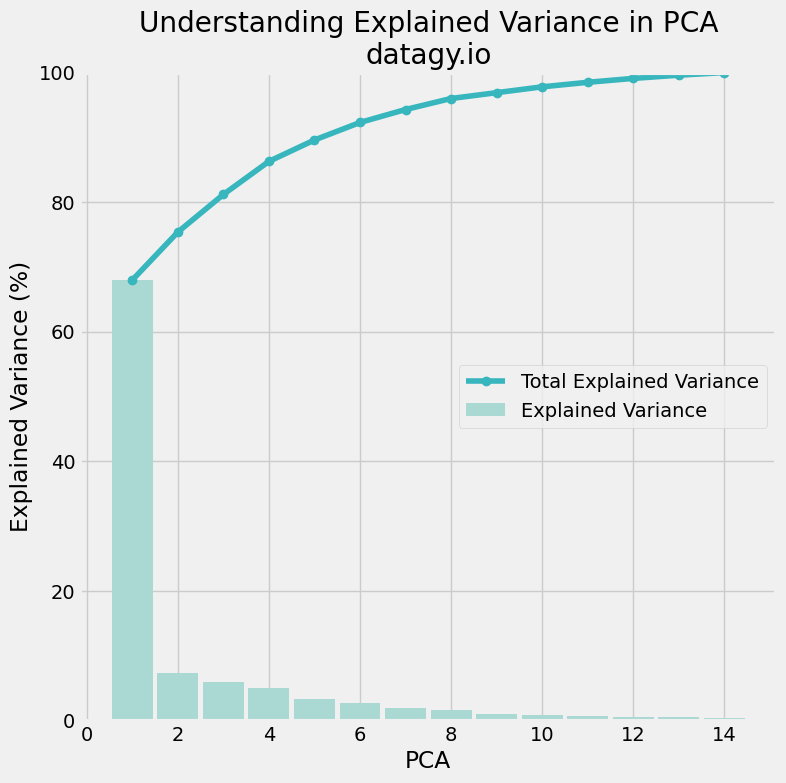

In [84]:
pca = PCA()

pca.fit(students_pca_new)
print(pca.explained_variance_ratio_)

expl_var = pca.explained_variance_ratio_
df_expl_var = pd.DataFrame(
    data=zip(range(1, len(expl_var) + 1), expl_var, expl_var.cumsum()), 
    columns=['PCA', 'Explained Variance (%)', 'Total Explained Variance (%)']
    ).set_index('PCA').mul(100).round(1)

fig, ax = plt.subplots(figsize=(8,8))
ax.bar(x=df_expl_var.index, height=df_expl_var['Explained Variance (%)'], label='Explained Variance', width=0.9, color='#AAD8D3')
ax.plot(df_expl_var['Total Explained Variance (%)'], label='Total Explained Variance', marker='o', c='#37B6BD')

plt.ylim(0, 100)
plt.ylabel('Explained Variance (%)')
plt.xlabel('PCA')
plt.grid(True, axis='y')
plt.title('Understanding Explained Variance in PCA\ndatagy.io')
plt.legend()

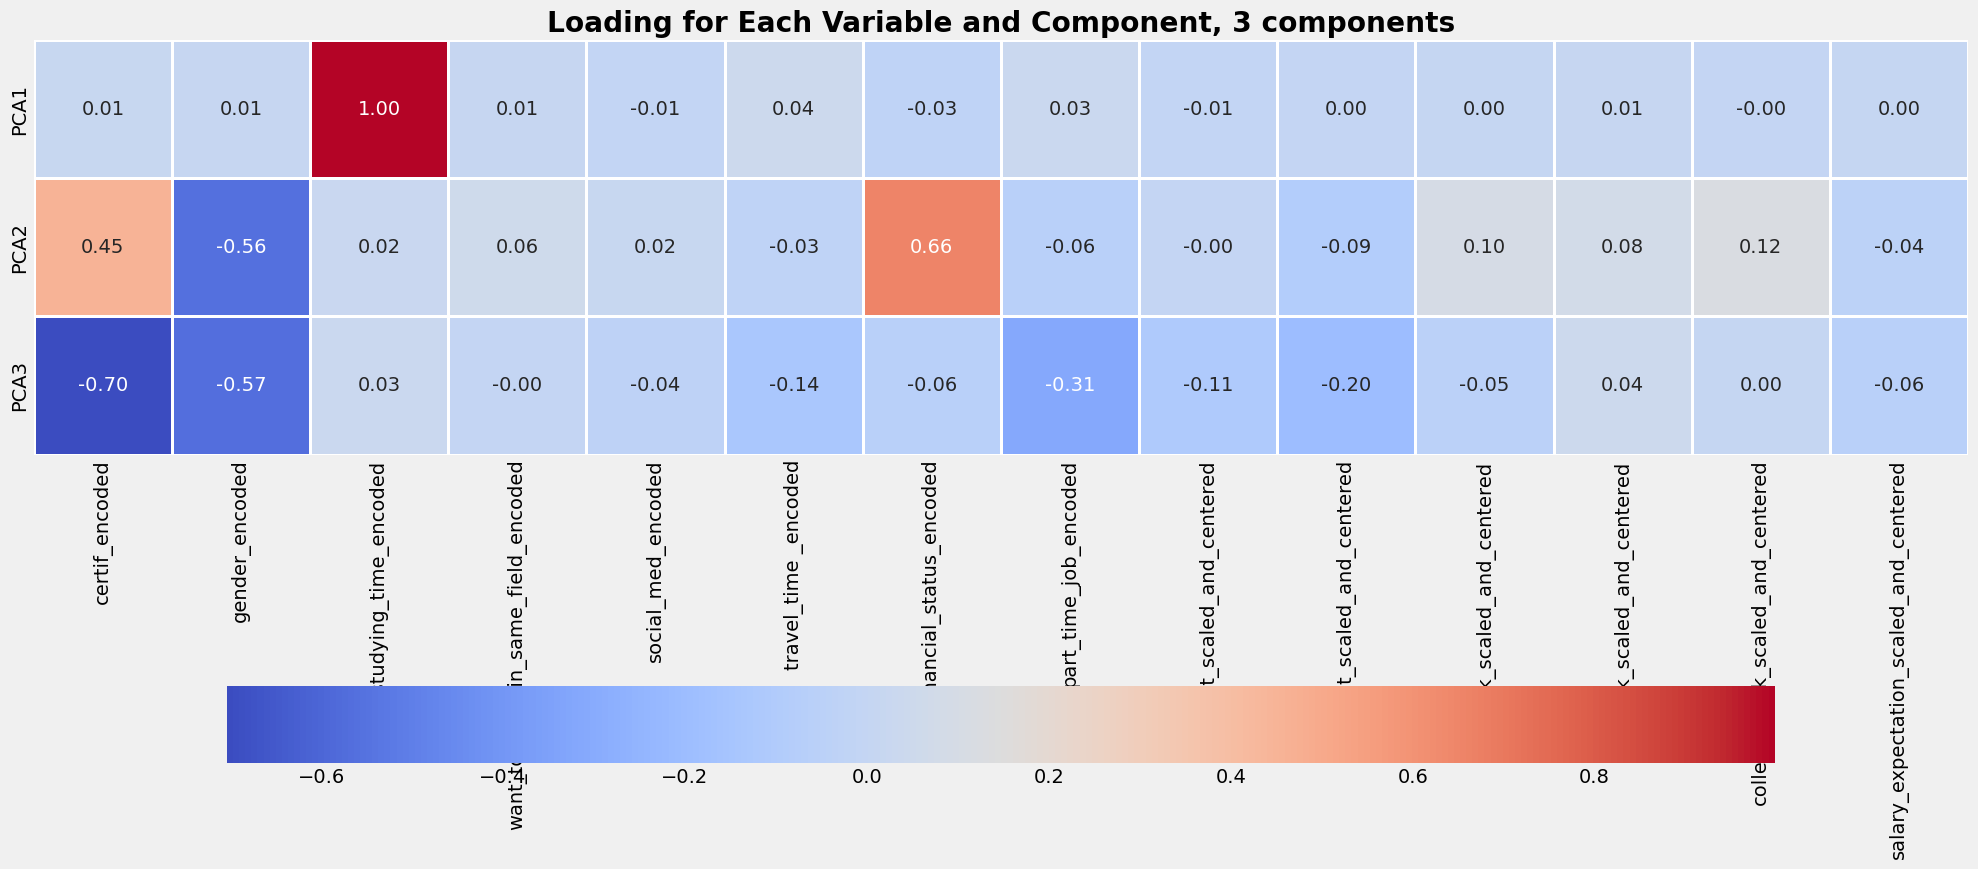

In [87]:
# it seems like with 3 components we can cover 80% of the variance in the data
pca_3 = PCA(3)

students_pca_3 = pca_3.fit_transform(students_pca_new)

fig, ax = plt.subplots(figsize=(20,16))

ax = sns.heatmap(
    pca_3.components_,
    cmap='coolwarm',
    yticklabels=[f'PCA{x}' for x in range(1,pca_3.n_components_+1)],
    xticklabels=list(students_pca_new.columns),
    linewidths=1,
    annot=True,
    fmt=',.2f',
    cbar_kws={"shrink": 0.8, "orientation": 'horizontal'}
    )

fig.tight_layout()
ax.set_aspect("equal")
plt.title('Loading for Each Variable and Component, 3 components', weight='bold')
plt.show()

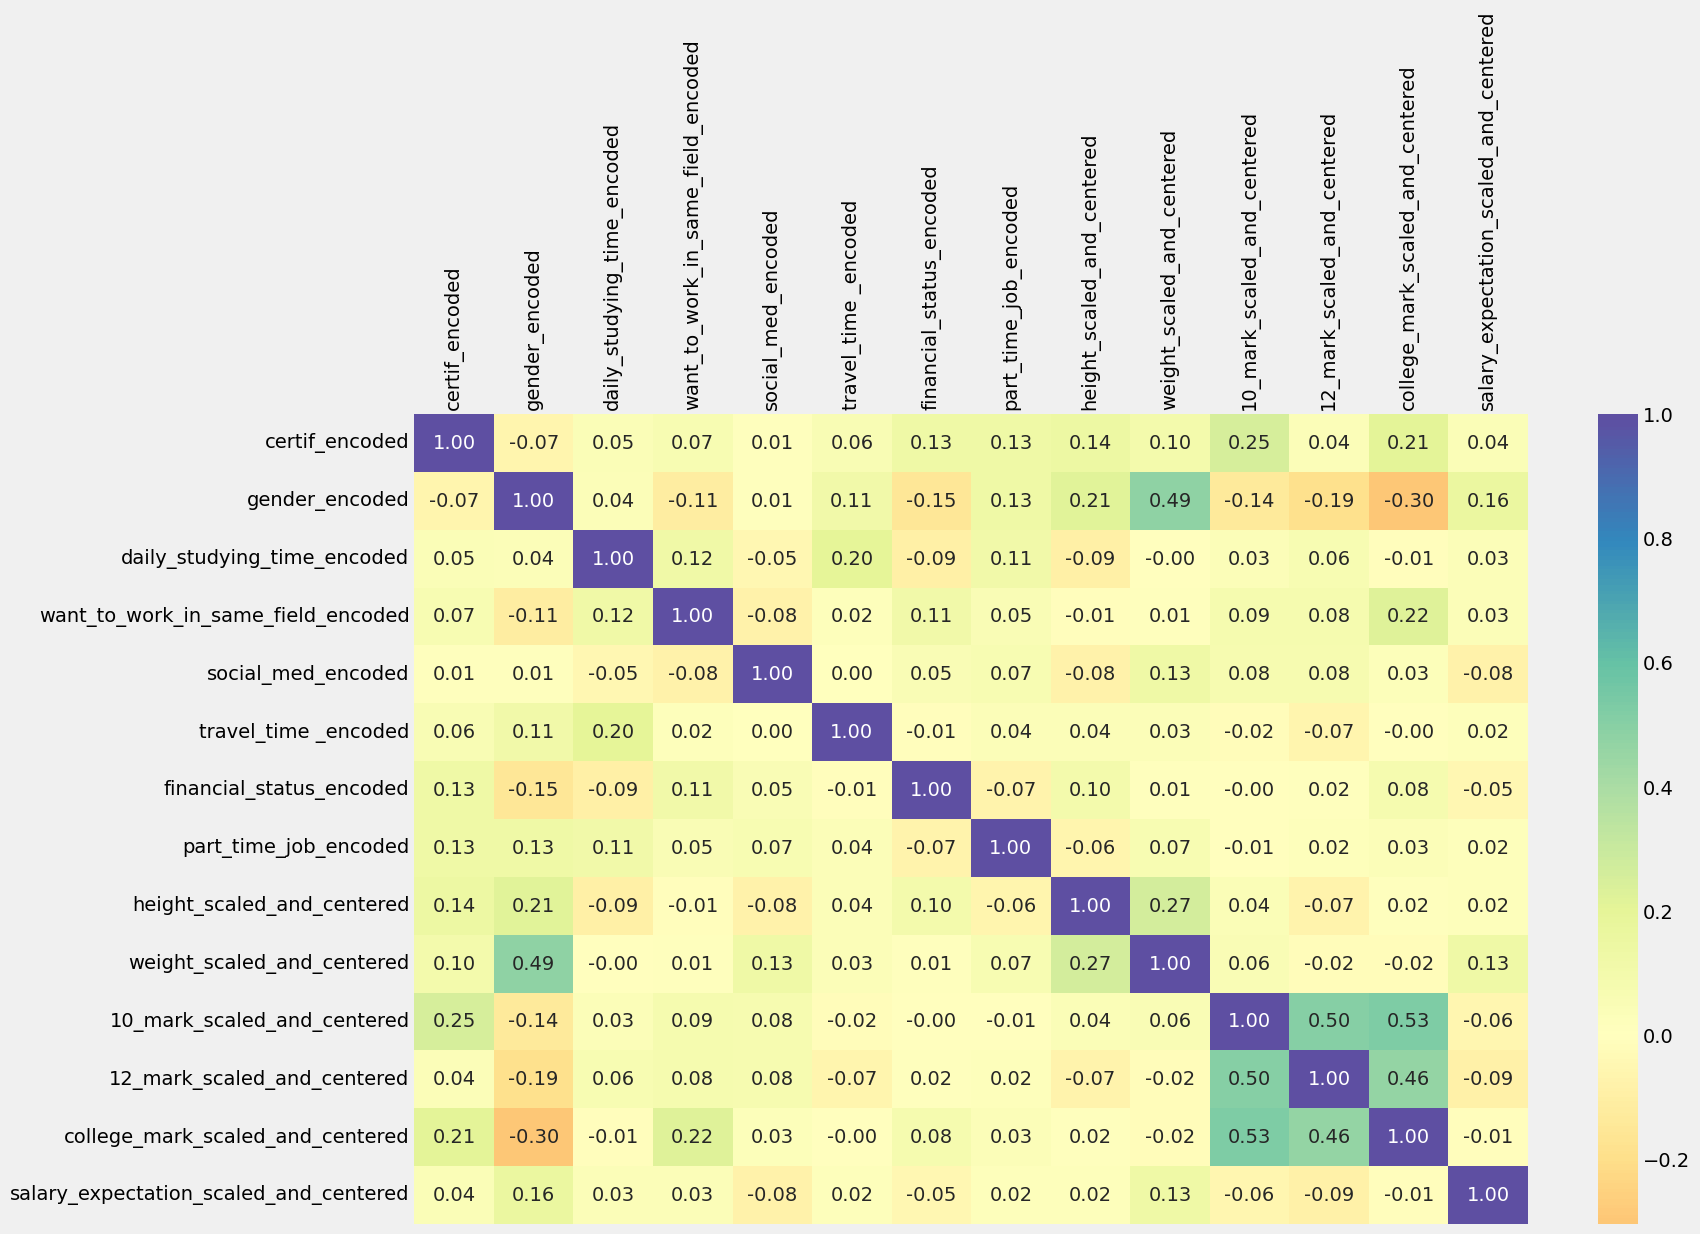

In [88]:
plt.subplots(figsize=(16, 10))
sns.heatmap(students_pca_new._get_numeric_data().corr(), annot=True, center = 0, fmt='.2f', cmap = 'Spectral')
plt.tick_params(labeltop = True, labelbottom=False, bottom = False, left = False)
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.show()